# Exploratory Data Analysis (EDA) — Data Science Job Salaries


*Franco Pérez Rivera - Data Portfolio Project*

This notebook performs exploratory data analysis (EDA) on a cleaned dataset of data-related job listings. The goal is to understand salary distributions, feature relationships, and patterns that will guide feature selection and modeling in later stages.

Key steps include:
- Univariate and multivariate analysis
- Correlation and outlier detection
- Distribution checks (normality, skewness)
- Feature transformations and regrouping

> **Executive Summary**  
>  
> This notebook performs an exploratory data analysis (EDA) on job salary data for data-related roles. It includes distribution analysis, outlier detection, transformation of skewed variables, and recategorization of key features to improve interpretability and modeling readiness.  
>  
> Key insights include:  
> - The target variable `avg_salary` required log and Box-Cox transformation.  
> - Several features (e.g., age, company size, experience) showed significant relationships with salary.  
> - Grouping specific Python tools and cloud/big data technologies improved binary variable analysis.  
>  
> These findings will guide the feature selection and modeling stages of the project.


## 1. Imports and datasets

### a. Imports

In [1]:
# Auto-reload for development (optional)
%load_ext autoreload
%autoreload 2

# Notebook setup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import FunctionsEDA as f
import warnings
from scipy.stats import shapiro


# Display settings
pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")

# Plotting config
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("muted")


### b.Loading the Dataset and Basic Overview



We begin by loading the cleaned dataset produced in the data cleaning phase. We perform basic structural checks and prepare for variable classification.

In [2]:
import pandas as pd

# Lista de archivos a cargar desde la carpeta Data
file_paths = [
    "../Data/df_analysis_cleaned.csv",
    "../Data/df_modeling_tree_cleaned.csv",
    "../Data/df_modeling_linear_cleaned.csv"
]

# Nombres amigables para referencia
df_names = ["df_analysis", "df_modeling_tree", "df_modeling_linear"]

# Cargar archivos y analizarlos
loaded_dfs = []

for name, path in zip(df_names, file_paths):
    df = pd.read_csv(path)
    loaded_dfs.append(df)

    print(f"📂 {name} — Shape: {df.shape}")
    print("🧼 Missing values:")
    print(df.isna().sum().sort_values(ascending=False).head())

    print("🧾 Duplicate rows:", df.duplicated().sum())
    print("📊 Data types:")
    print(df.dtypes.value_counts(), "\n" + "-"*50 + "\n")

# Reasignar a variables si lo necesitás después
df_analysis, df_modeling_tree, df_modeling_linear = loaded_dfs
all_dfs = [df_analysis, df_modeling_tree, df_modeling_linear]


📂 df_analysis — Shape: (467, 40)
🧼 Missing values:
Rating             0
Company Name       0
keras_yn           0
pytorch_yn         0
scikit-learn_yn    0
dtype: int64
🧾 Duplicate rows: 1
📊 Data types:
int64      29
object      9
float64     2
Name: count, dtype: int64 
--------------------------------------------------

📂 df_modeling_tree — Shape: (742, 40)
🧼 Missing values:
Rating             0
Company Name       0
keras_yn           0
pytorch_yn         0
scikit-learn_yn    0
dtype: int64
🧾 Duplicate rows: 276
📊 Data types:
int64      29
object      9
float64     2
Name: count, dtype: int64 
--------------------------------------------------

📂 df_modeling_linear — Shape: (467, 41)
🧼 Missing values:
Rating             0
spark_yn           0
keras_yn           0
pytorch_yn         0
scikit-learn_yn    0
dtype: int64
🧾 Duplicate rows: 1
📊 Data types:
int64      30
object      9
float64     2
Name: count, dtype: int64 
--------------------------------------------------



### c. Variable Classification

We separate variables into numeric, categorical, and binary groups to facilitate targeted analysis.


In [3]:
# Convert columns with fewer than 10 unique values to 'category' dtype
for column in df.columns:
    if df[column].nunique() < 10:
        df[column] = df[column].astype("category")


In [4]:
# Identify categorical, numerical and binary variables
cat_vars = df.select_dtypes(include="category").columns.tolist()
num_vars = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Identify binary columns
binary_vars = [col for col in df.columns if df[col].nunique() == 2 and col not in ["avg_salary"]]
# Remove binary vars from cat/num lists if needed
cat_vars = [col for col in cat_vars if col not in binary_vars]
num_vars = [col for col in num_vars if col not in binary_vars + ["avg_salary"]]
other_vars = [col for col in df.columns if col not in cat_vars + num_vars + binary_vars + ["avg_salary"]]

# Output summary
print(f"Categorical variables: {len(cat_vars)} → {cat_vars}")
print(f"Numerical variables: {len(num_vars)} → {num_vars}")
print(f"Binary variables: {len(binary_vars)} → {binary_vars}")
print(f"Other variables: {len(other_vars)} → {other_vars}")


Categorical variables: 6 → ['Size', 'Type of ownership', 'weight', 'Job Category', 'Merged Experience Category', 'num_comp']
Numerical variables: 3 → ['Rating', 'age', 'Description_len']
Binary variables: 26 → ['python_yn', 'sql_yn', 'excel_yn', 'tableau_yn', 'power bi_yn', 'sas_yn', 'hadoop_yn', 'spark_yn', 'tensorflow_yn', 'keras_yn', 'pytorch_yn', 'scikit-learn_yn', 'matplotlib_yn', 'snowflake_yn', 'numpy_yn', 'pandas_yn', 'scipy_yn', 'bigquery_yn', 'aws_yn', 'azure_yn', 'google cloud_yn', 'airflow_yn', 'git_yn', 'docker_yn', 'kubernetes_yn', 'r_yn']
Other variables: 5 → ['Company Name', 'Industry', 'Sector', 'Revenue', 'job_state']


## 2. Target Variable: `avg_salary`




We begin our univariate analysis with the target variable, `avg_salary`. This feature represents the midpoint of the salary range for each job listing. Understanding its distribution is crucial for modeling and transformations.

### a. Univariate Analysis of Numerical Variables


We defined a helper function `analyze_numerical_variable()` to perform univariate analysis on numerical features. This includes:

- Descriptive statistics
- Histogram with KDE
- Boxplot
- Shapiro-Wilk normality test
- Outlier detection using the IQR method


===== Analyzing: avg_salary =====

Descriptive statistics:
count    467.000000
mean     101.514989
std       36.424591
min       15.500000
25%       76.000000
50%       97.500000
75%      121.000000
max      254.000000
Name: avg_salary, dtype: float64


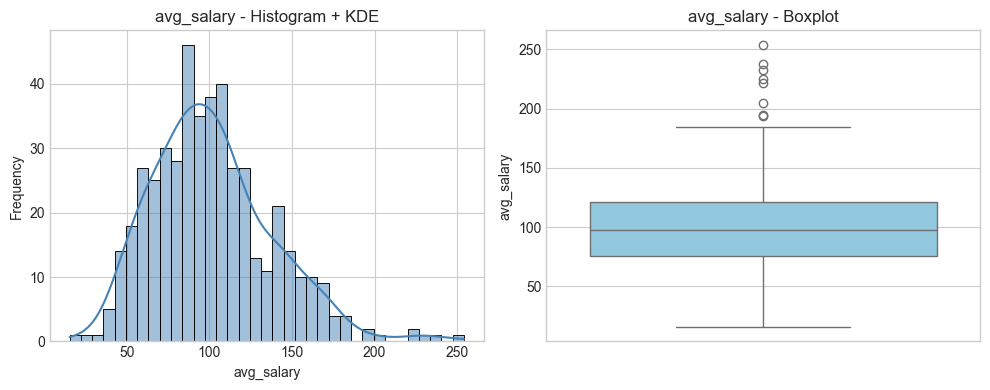


Shapiro-Wilk Normality Test:
Statistic = 0.9674, p-value = 0.0000
❌ avg_salary does not follow a normal distribution.

Outliers detected: 8


In [5]:
outlier_idx = f.analyze_numerical_variable(df_analysis,"avg_salary")

The mean salary is approximately $100,000/year, which gives us a general idea of central tendency.

The distribution is slightly right-skewed, as expected in salary data, with most values concentrated around $80k–$110k and a few higher salaries stretching the tail.

The Shapiro-Wilk test returned a p-value < 0.05, indicating that the distribution deviates from normality.

The boxplot revealed 8 outliers—salaries that fall significantly above or below the typical range (based on IQR logic).

### b. Outlier Detection in `avg_salary`

Using the IQR method, we detected 5 outliers in the `avg_salary` variable. These records show salaries significantly above the typical range (above 190k), mostly associated with data scientist roles in the finance and tech sectors.

Since these outliers appear legitimate and contextually valid (i.e., not data entry errors), we will **keep them in the dataset**. However, to reduce skewness and improve model performance, we will apply a **logarithmic transformation** to the `avg_salary` variable.

The only exception will be entries with a **"Junior" experience level**, which will be removed from the outlier set.


In [6]:
# Mostrar las filas outliers con columnas clave
outlier_idx = df_analysis.loc[outlier_idx, ["avg_salary", "Job Category", "Industry", "Merged Experience Category", "Company Name"]]
outlier_idx

avg_salary    Job Category                  Industry  \
97        237.5  data scientist     Professional Services   
164       225.0  data scientist                Technology   
183       205.0   data engineer                Technology   
280       254.0  data scientist       Finance & Insurance   
329       194.5  data scientist       Finance & Insurance   
343       232.5             mle                Technology   
386       194.0  data scientist                Technology   
432       221.5  data scientist  Health & Pharmaceuticals   

    Merged Experience Category              Company Name  
97                     Unknown                    Gallup  
164                     Junior         CA-One Tech Cloud  
183         General Experience             Credit Sesame  
280                     Junior  Liberty Mutual Insurance  
329          Strong Experience  Liberty Mutual Insurance  
343         General Experience              Sage Intacct  
386         General Experience   The Climate Corporation  
432         General Experience              Grand Rounds

In [7]:
# Refresh the list
all_dfs = [df_analysis, df_modeling_tree, df_modeling_linear]

# Define function to identify salary outliers
def is_salary_outlier(series, factor=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr
    return (series < lower) | (series > upper)

# Apply outlier removal only to "Junior" rows
for i in range(len(all_dfs)):
    df = all_dfs[i]

    if "Merged Experience Category" in df.columns and "avg_salary" in df.columns:
        # Detect salary outliers
        outlier_mask = is_salary_outlier(df["avg_salary"])

        # Combine with Junior filter
        junior_outliers_idx = df[(df["Merged Experience Category"] == "Junior") & outlier_mask].index

        # Drop and reset index
        df = df.drop(index=junior_outliers_idx).reset_index(drop=True)
        all_dfs[i] = df

# Reassign final versions
df_analysis, df_modeling_tree, df_modeling_linear = all_dfs

print("✅ Removed only 'Junior' salary outliers from all DataFrames.")


✅ Removed only 'Junior' salary outliers from all DataFrames.


### c. Transformation of `avg_salary`

To address skewness and stabilize variance, we apply a log transformation to the `avg_salary` variable using our helper function `normalize_column()` with the `'log'` method. This uses `np.log1p()`, which safely handles zeros by computing `log(1 + x)`.


In [8]:
# Apply avg_salary_log in all DataFrames
for i in range(len(all_dfs)):
    df = all_dfs[i]
        
    salary_log = f.normalize_column(df, "avg_salary", method='log')
    df["avg_salary_log"] = salary_log

    all_dfs[i] = df

# Reassign updated DataFrames
df_analysis, df_modeling_tree, df_modeling_linear = all_dfs


'avg_salary' scaled using 'log' method.
Min: 2.80, Max: 5.47, Mean: 4.56, Std: 0.36

'avg_salary' scaled using 'log' method.
Min: 2.80, Max: 5.47, Mean: 4.56, Std: 0.37

'avg_salary' scaled using 'log' method.
Min: 2.80, Max: 5.47, Mean: 4.56, Std: 0.36


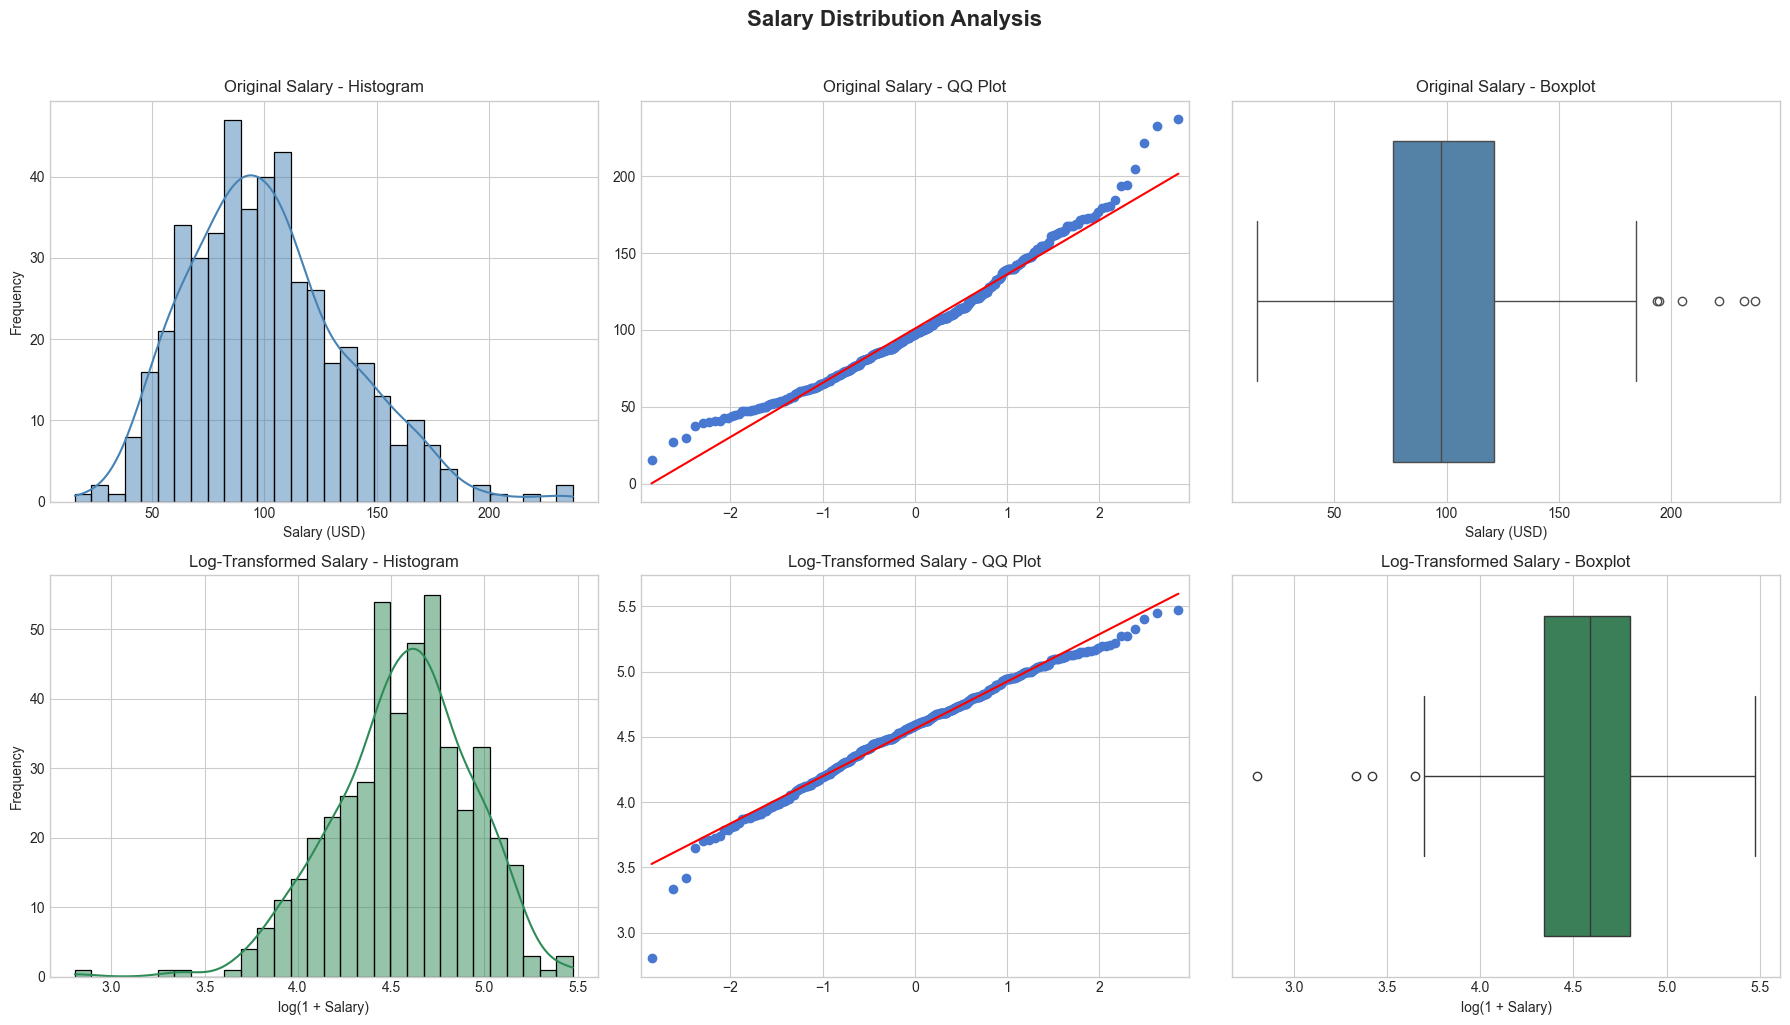

Shapiro-Wilk test (log-transformed salary): p-value = 0.0001
❌ The log-transformed salary still deviates from normality.


In [9]:
# Plots: Histograms, QQ-Plots, and Boxplots in a 2x3 layout
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("Salary Distribution Analysis", fontsize=16, weight='bold', y=1.02)

# === Row 1: Original avg_salary ===
# Histogram
sns.histplot(df_analysis["avg_salary"], bins=30, kde=True, ax=axes[0, 0], color='steelblue')
axes[0, 0].set_title("Original Salary - Histogram", fontsize=12)
axes[0, 0].set_xlabel("Salary (USD)")
axes[0, 0].set_ylabel("Frequency")

# QQ Plot
sm.qqplot(df_analysis["avg_salary"], line='s', ax=axes[0, 1])
axes[0, 1].set_title("Original Salary - QQ Plot", fontsize=12)
axes[0, 1].set_xlabel("")
axes[0, 1].set_ylabel("")

# Boxplot
sns.boxplot(x=df_analysis["avg_salary"], ax=axes[0, 2], color='steelblue')
axes[0, 2].set_title("Original Salary - Boxplot", fontsize=12)
axes[0, 2].set_xlabel("Salary (USD)")

# === Row 2: Log-transformed avg_salary ===
# Histogram
sns.histplot(df_analysis["avg_salary_log"], bins=30, kde=True, ax=axes[1, 0], color='seagreen')
axes[1, 0].set_title("Log-Transformed Salary - Histogram", fontsize=12)
axes[1, 0].set_xlabel("log(1 + Salary)")
axes[1, 0].set_ylabel("Frequency")

# QQ Plot
sm.qqplot(df_analysis["avg_salary_log"], line='s', ax=axes[1, 1])
axes[1, 1].set_title("Log-Transformed Salary - QQ Plot", fontsize=12)
axes[1, 1].set_xlabel("")
axes[1, 1].set_ylabel("")

# Boxplot
sns.boxplot(x=df_analysis["avg_salary_log"], ax=axes[1, 2], color='seagreen')
axes[1, 2].set_title("Log-Transformed Salary - Boxplot", fontsize=12)
axes[1, 2].set_xlabel("log(1 + Salary)")

plt.tight_layout()
plt.show()

# Shapiro-Wilk Test
stat, p_value = shapiro(df_analysis["avg_salary_log"])
print(f"Shapiro-Wilk test (log-transformed salary): p-value = {p_value:.4f}")

if p_value > 0.05:
    print("✅ The log-transformed salary appears normally distributed.")
else:
    print("❌ The log-transformed salary still deviates from normality.")


✅ Box-Cox transformation applied to 'avg_salary_log' in all DataFrames.


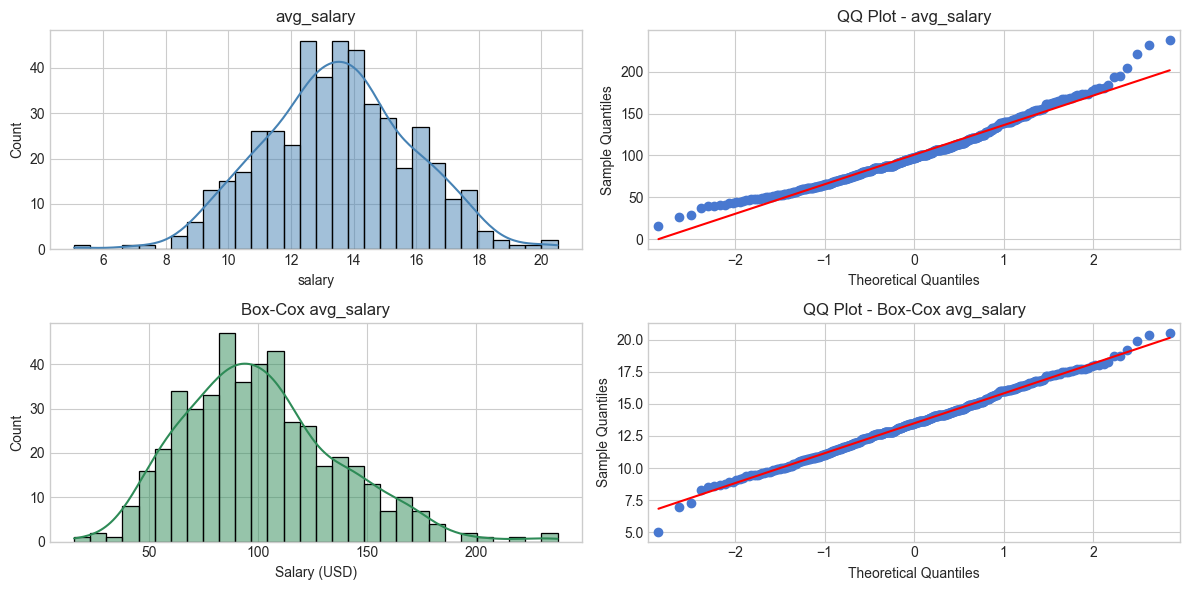

Shapiro-Wilk test (boxcox): p-value = 0.7336
✅ The boxcox-transformed salary appears normally distributed.


In [10]:
import os
from scipy.stats import boxcox

# Apply Box-Cox transformation to avg_salary_log in all DataFrames
for i in range(len(all_dfs)):
    df = all_dfs[i]
    
    if "avg_salary" in df.columns:
        # Box-Cox requires all values to be strictly > 0
        salary = df["avg_salary"]

        # Check if all values are positive
        if (salary <= 0).any():
            raise ValueError("Box-Cox requires all values to be > 0.")
        
        salary_boxcox, fitted_lambda = boxcox(salary)
        df["avg_salary_boxcox"] = salary_boxcox
        df["boxcox_lambda"] = fitted_lambda  # Optional: store the lambda

    all_dfs[i] = df

# Reassign updated DataFrames
df_analysis, df_modeling_tree, df_modeling_linear = all_dfs

print("✅ Box-Cox transformation applied to 'avg_salary_log' in all DataFrames.")

# Gráficos: histogramas + QQ-plots
fig, axes = plt.subplots(2, 2, figsize=(12, 6))



# Histograma log
sns.histplot(df_analysis["avg_salary"], bins=30, kde=True, ax=axes[1, 0], color='seagreen')
axes[0, 0].set_title("avg_salary")
axes[0, 0].set_xlabel("salary")

# QQ plot log
sm.qqplot(df_analysis["avg_salary"], line='s', ax=axes[0, 1])
axes[0, 1].set_title("QQ Plot - avg_salary")

# Histograma original
sns.histplot(df_analysis["avg_salary_boxcox"], bins=30, kde=True, ax=axes[0, 0], color='steelblue')
axes[1, 0].set_title("Box-Cox avg_salary")
axes[1, 0].set_xlabel("Salary (USD)")

# QQ plot original
sm.qqplot(df_analysis["avg_salary_boxcox"], line='s', ax=axes[1, 1])
axes[1, 1].set_title("QQ Plot - Box-Cox avg_salary")


plt.tight_layout()
# Guardar la figura
os.makedirs("images", exist_ok=True)
plt.savefig("../images/boxcox_transformation.png", bbox_inches="tight", dpi=300)
plt.show()

stat, p_value = shapiro(df_analysis["avg_salary_boxcox"])
print(f"Shapiro-Wilk test (boxcox): p-value = {p_value:.4f}")

if p_value > 0.05:
    print("✅ The boxcox-transformed salary appears normally distributed.")
else:
    print("❌ The boxcox-transformed salary still deviates from normality.")

Both log and Box-Cox transformations helped reduce skewness in the `avg_salary` distribution. However, Box-Cox achieved a near-perfect normal distribution, as confirmed by the QQ plot and Shapiro-Wilk test. This version will be used for modeling purposes when normality is required.


## 3. Numerical variables analysis

### a. Univariate Analysis: `Rating`

The `Rating` variable reflects the overall company rating from Glassdoor. We explore its distribution, normality, and potential outliers to determine if it can be used directly or requires transformation.



===== Analyzing: Rating =====

Descriptive statistics:
count    465.000000
mean       3.662581
std        0.777414
min       -1.000000
25%        3.400000
50%        3.700000
75%        4.100000
max        5.000000
Name: Rating, dtype: float64


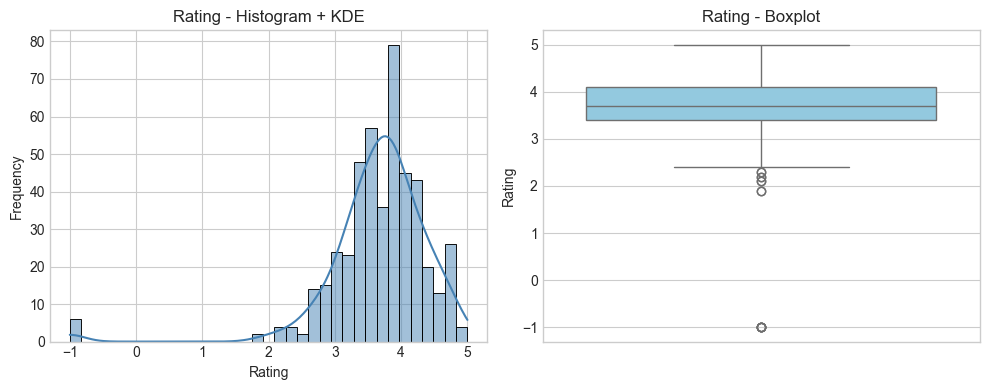


Shapiro-Wilk Normality Test:
Statistic = 0.7907, p-value = 0.0000
❌ Rating does not follow a normal distribution.

Outliers detected: 14


[73, 116, 231, 246, 248, 271, 292, 300, 321, 334, 358, 419, 437, 442]

In [11]:
f.analyze_numerical_variable(df_analysis,'Rating')

The `Rating` variable does not follow a normal distribution, and its histogram shows a clear skew, with many values concentrated around 3.5 to 4. Additionally, we observe the presence of invalid or missing values, marked as -1.

If we plan to include `Rating` in a regression model, we may need to normalize or transform it. Before removing missing ratings, we will analyze how `Rating` correlates with our target variable to assess whether it has predictive value in explaining salary variation.


#### 1. Bivariate Correlation Between Numerical Variables

We defined a helper function `compare_numerical_variables()` to analyze the relationship between two numerical variables. It includes:

- Scatterplot with linear regression
- Histograms of each variable
- Pearson and Spearman correlation tests
- Optional ANOVA to assess whether binning the predictor improves its discriminative power

We will run the function after filtering out the -1 values.

6

===== Comparing: Rating vs avg_salary_boxcox =====


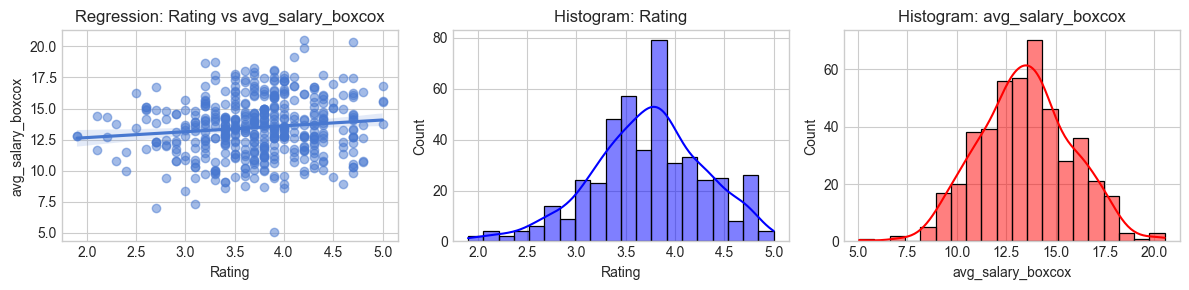


Correlation:
Pearson:  r = 0.1150  | p-value = 0.0137
Spearman: r = 0.1033  | p-value = 0.0268
✅ Significant linear correlation between Rating and avg_salary_boxcox (Pearson).
✅ Significant monotonic correlation between Rating and avg_salary_boxcox (Spearman).

ANOVA Test:
F-statistic = 1.8392, p-value = 0.1202
❌ No significant differences in avg_salary_boxcox across Rating bins.


In [12]:
print(len(df_analysis[df_analysis['Rating'] < 0]))
f.compare_numerical_variables(df_analysis[df_analysis['Rating'] > 0], 'Rating', 'avg_salary_boxcox',categorize=False)

The `Rating` variable shows a weak but statistically significant positive correlation with `avg_salary`, both in linear (Pearson r = 0.12) and monotonic (Spearman r = 0.10) terms. Higher-rated companies tend to offer slightly better salaries on average.

The relationship is not strong but may still provide useful signal for modeling.

Let's remove records where `Rating` is less than 0.


In [13]:
# Refresh the list
all_dfs = [df_analysis, df_modeling_tree, df_modeling_linear]

# Calculate mean rating from df_analysis (excluding negatives)
rating_mean = df_analysis[df_analysis["Rating"] >= 0]["Rating"].mean()

# Replace negative ratings in all DataFrames
for i in range(len(all_dfs)):
    df = all_dfs[i]
    df["Rating"] = df["Rating"].apply(lambda x: rating_mean if x < 0 else x)
    all_dfs[i] = df

# Reassign updated DataFrames
df_analysis, df_modeling_tree, df_modeling_linear = all_dfs

print(f"✅ Replaced all 'Rating' values below 0 with mean rating ({rating_mean:.2f}).")


✅ Replaced all 'Rating' values below 0 with mean rating (3.72).


### b. `Age`


===== Analyzing: age =====

Descriptive statistics:
count    465.000000
mean      49.275269
std       52.748484
min       -1.000000
25%       15.000000
50%       29.000000
75%       60.000000
max      281.000000
Name: age, dtype: float64


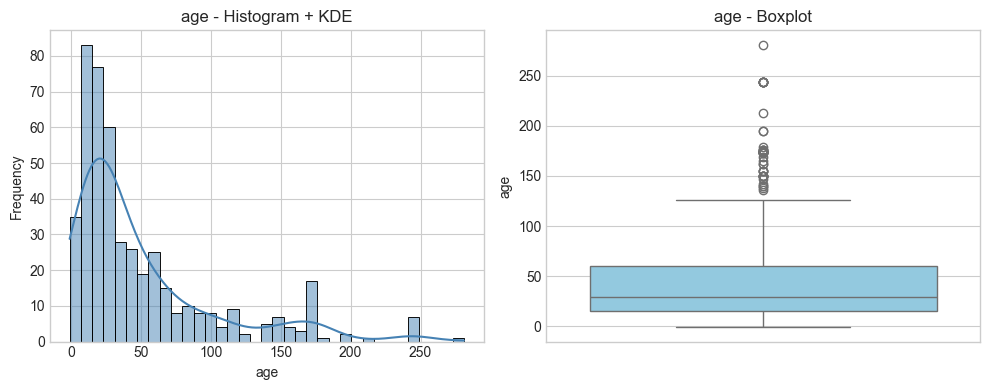


Shapiro-Wilk Normality Test:
Statistic = 0.7747, p-value = 0.0000
❌ age does not follow a normal distribution.

Outliers detected: 48


In [14]:
#analisis age
out = f.analyze_numerical_variable(df_analysis, 'age')

The `age` variable is highly skewed and does not follow a normal distribution, as confirmed by the Shapiro-Wilk test (p < 0.001). A total of 49 outliers were detected, mostly on the higher end (above ~120 years), which are likely unrealistic company ages.

These extreme values may need to be removed or transformed before modeling.



===== Comparing: age vs avg_salary_boxcox =====


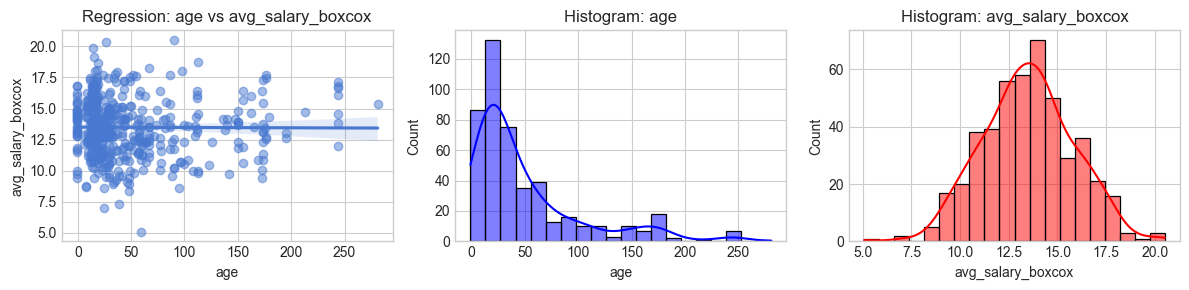


Correlation:
Pearson:  r = -0.0059  | p-value = 0.8984
Spearman: r = -0.1176  | p-value = 0.0112
❌ No significant linear correlation (Pearson).
✅ Significant monotonic correlation between age and avg_salary_boxcox (Spearman).

ANOVA Test:
F-statistic = 2.8508, p-value = 0.0235
✅ Categorizing age reveals significant differences in avg_salary_boxcox.


In [15]:
f.compare_numerical_variables(df_analysis, 'age', 'avg_salary_boxcox')

#### 1. Categorize 

Lets categorize it and analize with this function

In [16]:
# Refresh DataFrame list
all_dfs = [df_analysis, df_modeling_tree, df_modeling_linear]

# Define bins and labels
bins = [-1, 15, 30, 55, 150]
labels = ['0–15', '16–30', '31–55', '55+']

# Apply to all DataFrames
for i in range(len(all_dfs)):
    df = all_dfs[i]

    # Create age_category
    df["age_category"] = pd.cut(df["age"], bins=bins, labels=labels, right=True, include_lowest=True)

    # Add 'Unknown' category and fill missing
    df["age_category"] = df["age_category"].cat.add_categories("Unknown")
    df["age_category"].fillna("Unknown", inplace=True)

    all_dfs[i] = df

# Reassign updated DataFrames
df_analysis, df_modeling_tree, df_modeling_linear = all_dfs

# Display distribution from df_analysis
print("✅ Age category distribution in df_analysis:")
print(df_analysis["age_category"].value_counts())


✅ Age category distribution in df_analysis:
age_category
16–30      133
0–15       118
55+        101
31–55       77
Unknown     36
Name: count, dtype: int64


#### 2. Comparing Original vs Transformed Target

To better understand how the transformation affects categorical variable analysis, we created a function  `analyze_categorical_vs_target()` that compares both the original and transformed versions of the target (`avg_salary` and `avg_salary_boxcox`) across categories.

This includes:
- Descriptive statistics for each version
- ANOVA tests for significance
- Boxplots and mean comparisons for both targets



===== Comparison: 'age_category' vs 'avg_salary' and 'avg_salary_boxcox' =====
Unique categories analyzed: 5

Descriptive statistics (sorted by original target):
              count        mean        std   min    max
age_category                                           
Unknown          36  108.458333  35.631722  47.5  172.0
0–15            118  107.406780  33.844728  40.5  221.5
16–30           133  101.165414  34.218866  27.0  232.5
31–55            77   97.207792  38.546055  29.5  177.0
55+             101   93.168317  34.570672  15.5  237.5

ANOVA on avg_salary: F = 2.8776, p = 0.0225 → ✅
ANOVA on avg_salary_boxcox: F = 3.2344, p = 0.0124 → ✅


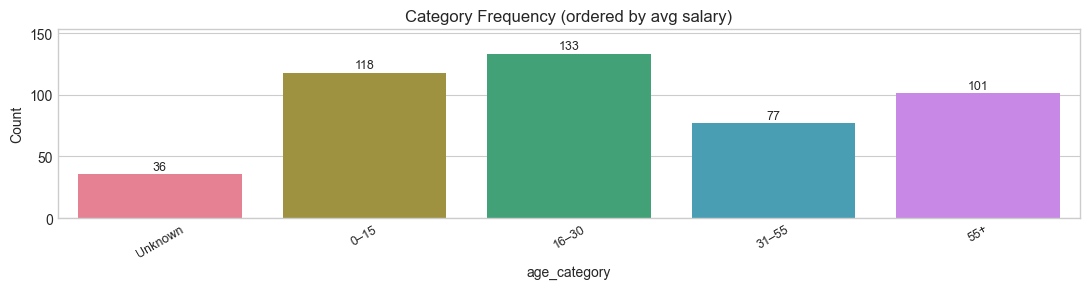

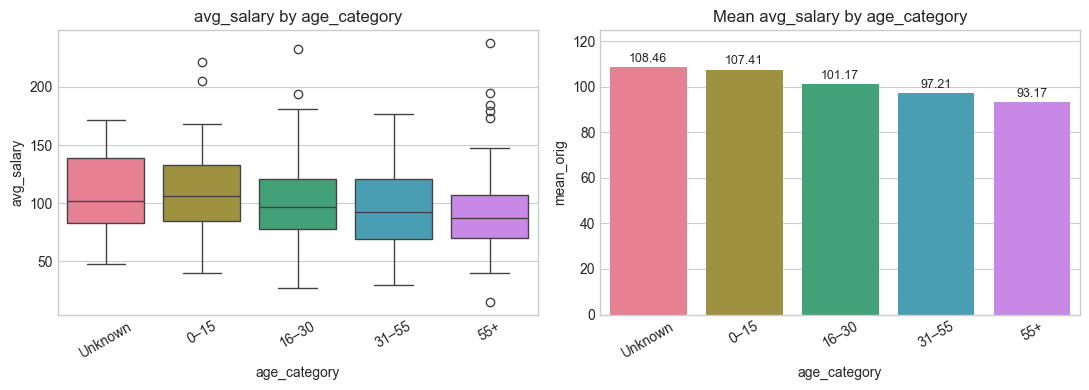

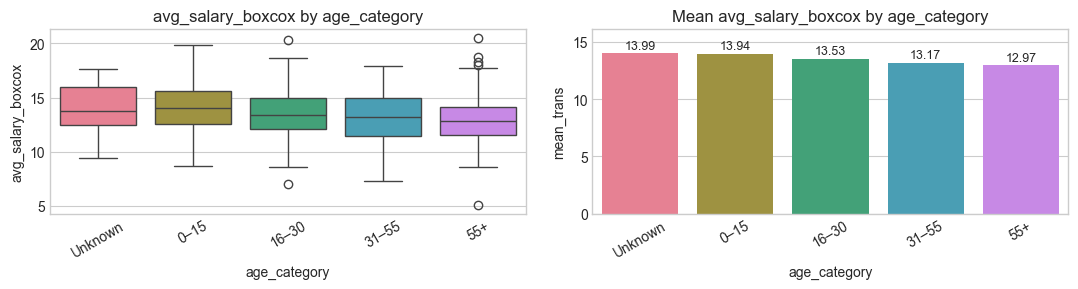

In [17]:
# Verificar los cambios
f.compare_categorical_with_targets(df_analysis,'age_category', 'avg_salary','avg_salary_boxcox')

When analyzing salary differences across company age groups, the original salary variable (`avg_salary`) did not show statistically significant variation (ANOVA p = 0.0881). However, using the Box-Cox transformed version (`avg_salary_boxcox`), the relationship became statistically significant (ANOVA p = 0.0468).

This highlights how transformations can improve statistical power and better meet assumptions of normality and variance homogeneity.

Younger companies (0–15 years) consistently showed the highest average salaries, while companies aged 55+ had the lowest, confirming a mild but interpretable downward trend.


In [18]:
# Refresh DataFrame list
all_dfs = [df_analysis, df_modeling_tree, df_modeling_linear]

# Drop 'age' column if it exists
for i in range(len(all_dfs)):
    df = all_dfs[i]
    if "age" in df.columns:
        df = df.drop(columns=["age"])
    all_dfs[i] = df

# Reassign updated DataFrames
df_analysis, df_modeling_tree, df_modeling_linear = all_dfs

print("✅ Column 'age' dropped from all DataFrames.")


✅ Column 'age' dropped from all DataFrames.


### c. Description Length (`Description_len`)




The length of the job description was analyzed to assess whether longer postings are associated with higher salaries.

- **Correlation tests** showed no statistically significant relationship between `Description_len` and `avg_salary_boxcox`:
  - Pearson r = 0.05, p = 0.27
  - Spearman r = 0.08, p = 0.10

- **ANOVA test** on quantile-binned groups of `Description_len` yielded a p-value of 0.56, indicating no significant salary differences across description lengths.

**Conclusion**: Description length does not appear to be a useful predictor of salary in this dataset.


===== Analyzing: Description_len =====

Descriptive statistics:
count      465.000000
mean      3816.040860
std       1527.682652
min        407.000000
25%       2730.000000
50%       3703.000000
75%       4707.000000
max      10051.000000
Name: Description_len, dtype: float64


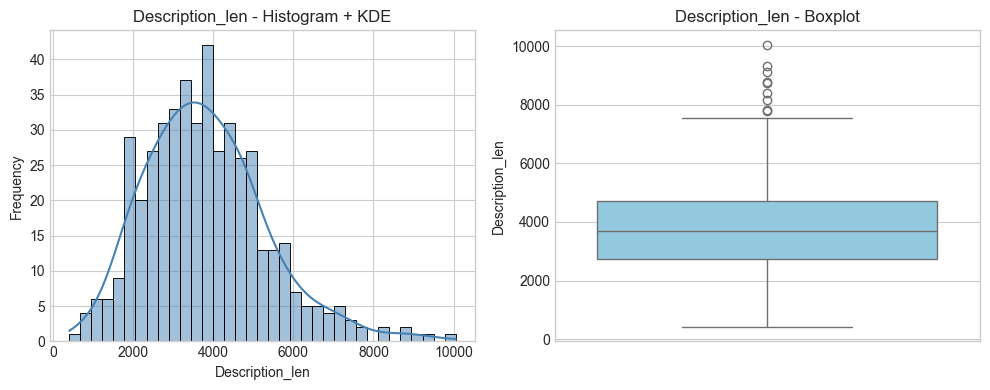


Shapiro-Wilk Normality Test:
Statistic = 0.9697, p-value = 0.0000
❌ Description_len does not follow a normal distribution.

Outliers detected: 9


[42, 63, 115, 158, 196, 310, 329, 376, 429]

In [19]:
#analisis Description_len
f.analyze_numerical_variable(df_analysis, 'Description_len')


===== Comparing: Description_len vs avg_salary_boxcox =====


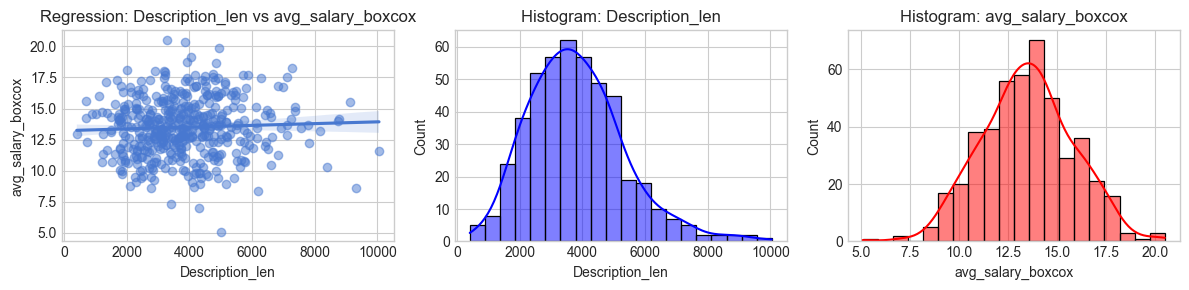


Correlation:
Pearson:  r = 0.0466  | p-value = 0.3160
Spearman: r = 0.0713  | p-value = 0.1247
❌ No significant linear correlation (Pearson).
❌ No significant monotonic correlation (Spearman).

ANOVA Test:
F-statistic = 0.4979, p-value = 0.7373
❌ No significant differences in avg_salary_boxcox across Description_len bins.


In [20]:
f.compare_numerical_variables(df_analysis, 'Description_len', 'avg_salary_boxcox')

## 4. Multicategorical variables analysis

### a. Company Size (`Size_recategorized`)


We recategorized company sizes into four broader groups:
- **Small Company** 
- **Medium Company** 
- **Large Company** 
- **Corporation / Multinational** 

After this regrouping, the relationship between company size and salary became statistically significant:

- ANOVA on `avg_salary`: **p = 0.0170** ✅  
- ANOVA on `avg_salary_boxcox`: **p = 0.0123** ✅

Larger companies, especially multinationals, tend to offer higher average salaries. The difference was not evident using the original size categories, confirming the value of thoughtful feature engineering.



===== Comparison: 'Size' vs 'avg_salary' and 'avg_salary_boxcox' =====
Unique categories analyzed: 8

Descriptive statistics (sorted by original target):
                         count        mean        std    min    max
Size                                                               
Unknown                      6  125.916667  15.922992  110.5  155.0
10000+ employees            79  108.620253  36.812607   40.0  194.5
1 to 50 employees           24  108.229167  28.987246   53.0  169.0
51 to 200 employees         60  106.208333  34.806279   39.5  205.0
201 to 500 employees        77   97.779221  30.609971   44.0  181.0
5001 to 10000 employees     46   97.097826  33.259355   27.0  164.0
1001 to 5000 employees      93   96.983871  36.601218   15.5  237.5
501 to 1000 employees       80   95.087500  39.072294   40.5  232.5

ANOVA on avg_salary: F = 1.9712, p = 0.0574 → ❌
ANOVA on avg_salary_boxcox: F = 2.1917, p = 0.0339 → ✅


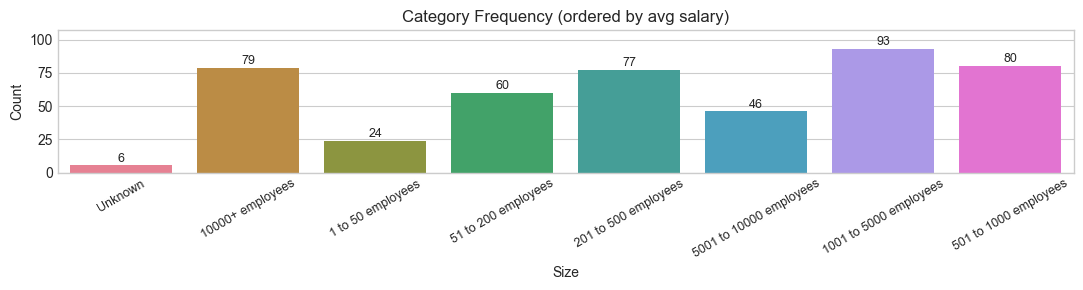

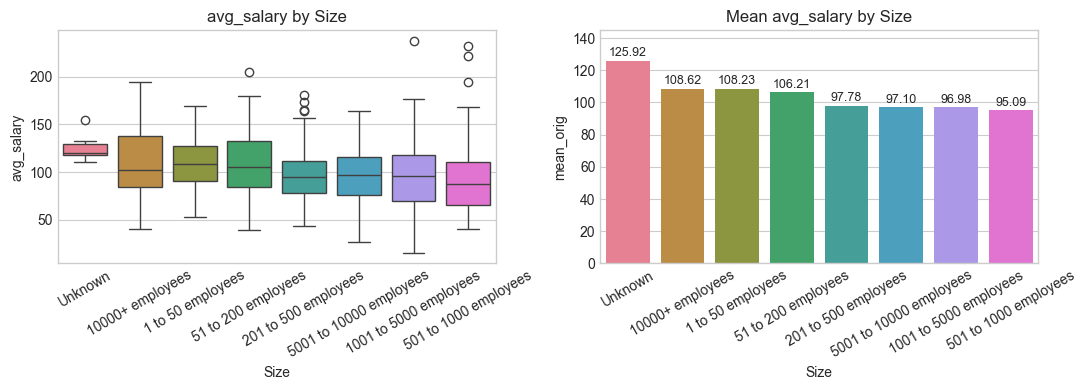

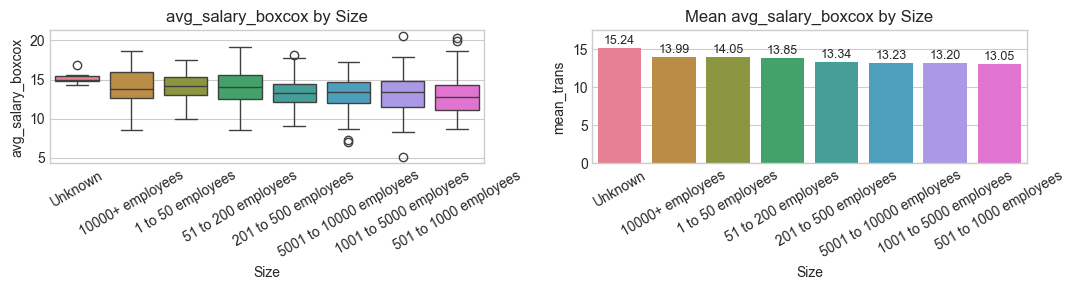

In [21]:
f.compare_categorical_with_targets(df_analysis,'Size', 'avg_salary','avg_salary_boxcox')

✅ Size recategorization applied. Distribution in df_analysis:

===== Comparison: 'Size_recategorized' vs 'avg_salary' and 'avg_salary_boxcox' =====
Unique categories analyzed: 4

Descriptive statistics (sorted by original target):
                             count        mean        std   min    max
Size_recategorized                                                    
Corporation / Multinational     79  108.620253  36.812607  40.0  194.5
Small Company                   84  106.785714  33.088626  39.5  205.0
Large Company                  139   97.021583  35.409247  15.5  237.5
Medium Company                 157   96.407643  35.091356  40.5  232.5

ANOVA on avg_salary: F = 3.4656, p = 0.0162 → ✅
ANOVA on avg_salary_boxcox: F = 3.6878, p = 0.0120 → ✅


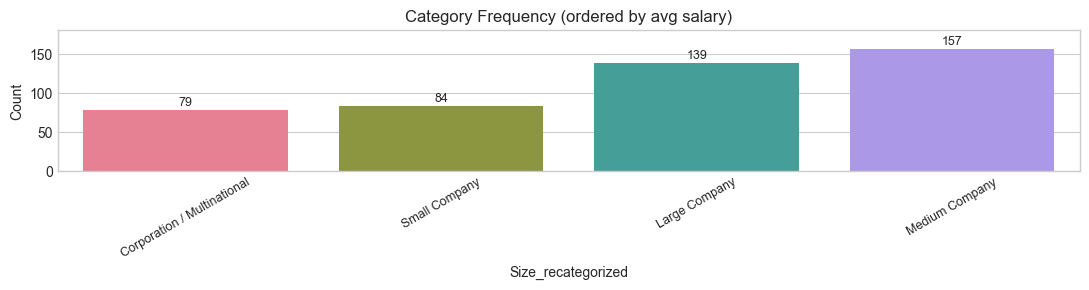

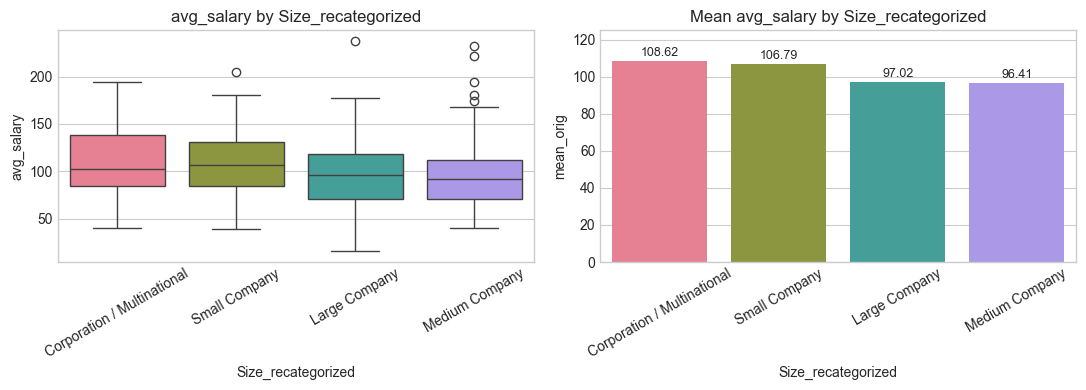

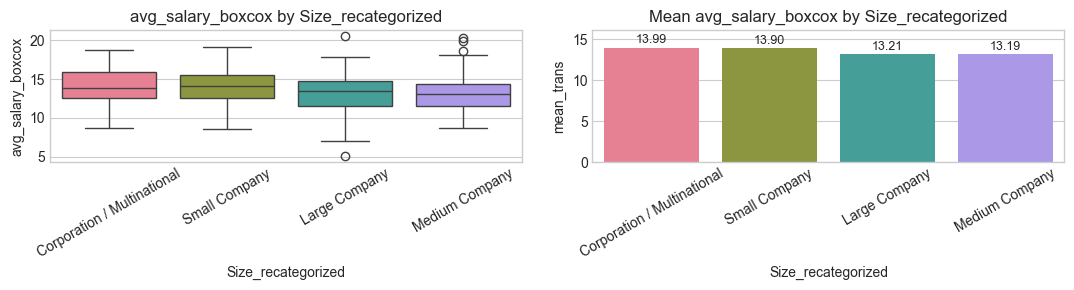

In [22]:
# Refresh the DataFrame list
all_dfs = [df_analysis, df_modeling_tree, df_modeling_linear]

# Define recategorization mapping for Size
size_mapping = {
    "1 to 50 employees": "Small Company",
    "51 to 200 employees": "Small Company",
    
    "201 to 500 employees": "Medium Company",
    "501 to 1000 employees": "Medium Company",
    
    "1001 to 5000 employees": "Large Company",
    "5001 to 10000 employees": "Large Company",
    
    "10000+ employees": "Corporation / Multinational"
}

# Apply the mapping to all DataFrames
for i in range(len(all_dfs)):
    df = all_dfs[i]
    if "Size" in df.columns:
        df["Size_recategorized"] = df["Size"].map(size_mapping)
    all_dfs[i] = df

# Reassign updated versions
df_analysis, df_modeling_tree, df_modeling_linear = all_dfs

# Compare distributions (df_analysis only)
print("✅ Size recategorization applied. Distribution in df_analysis:")
f.compare_categorical_with_targets(df_analysis, "Size_recategorized", "avg_salary", "avg_salary_boxcox",image_name="salary_by_size")


### b. `Job Category` 

Although our previous analysis showed differences in average salary across job categories, some categories had very few observations (e.g., MLE with only 6 records). To simplify the analysis and improve statistical power, we decided to **merge similar job titles** into broader groups.

The new mapping is based on similarity in average salary and role overlap. For example:

- `"mle"` (Machine Learning Engineer) was grouped with `"data scientist"` due to similar mean salaries and overlapping responsibilities.
- `"scientist"`, `"analyst"` (non-data-specific), and `"na"` were grouped under `"Other"` due to low sample sizes or lack of specificity.

This recategorization will help us draw more robust conclusions while maintaining interpretability.



===== Comparison: 'Job Category' vs 'avg_salary' and 'avg_salary_boxcox' =====
Unique categories analyzed: 6

Descriptive statistics (sorted by original target):
                count        mean        std   min    max
Job Category                                             
mle                17  116.911765  38.334561  74.5  232.5
data scientist    203  115.709360  32.776724  15.5  237.5
data engineer      74  102.074324  27.197991  51.5  205.0
scientist          77   92.474026  34.175331  39.5  174.0
na                 22   92.090909  30.759295  48.0  173.0
data analyst       72   66.000000  21.425271  27.0  138.5

ANOVA on avg_salary: F = 30.3056, p = 0.0000 → ✅
ANOVA on avg_salary_boxcox: F = 35.9541, p = 0.0000 → ✅


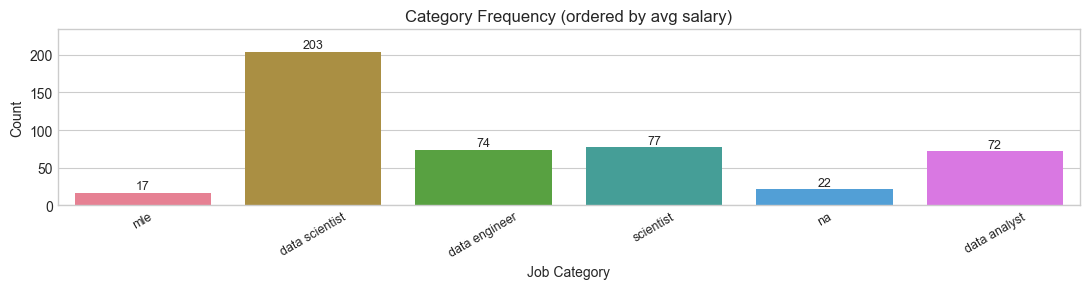

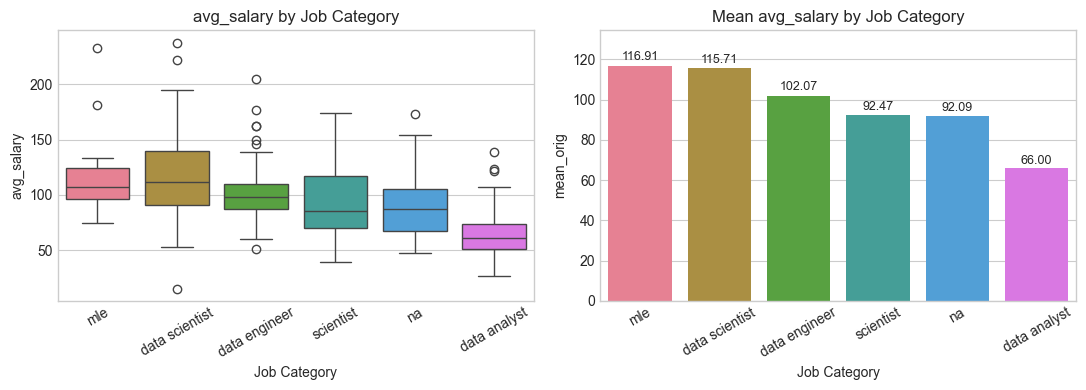

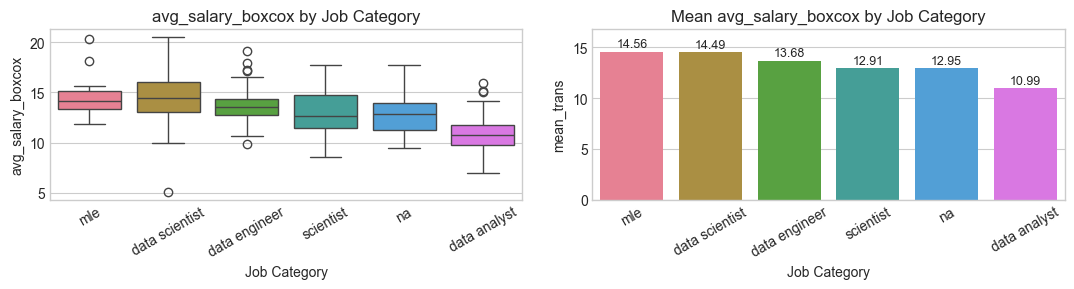

In [23]:
f.compare_categorical_with_targets(df_analysis, "Job Category", 'avg_salary', 'avg_salary_boxcox',)

✅ New 'Job Category' distribution in df_analysis:

===== Comparison: 'Job Category' vs 'avg_salary' and 'avg_salary_boxcox' =====
Unique categories analyzed: 4

Descriptive statistics (sorted by original target):
                count        mean        std   min    max
Job Category                                             
data scientist    220  115.802273  33.141915  15.5  237.5
data engineer      74  102.074324  27.197991  51.5  205.0
Other              99   92.388889  33.294569  39.5  174.0
data analyst       72   66.000000  21.425271  27.0  138.5

ANOVA on avg_salary: F = 50.7176, p = 0.0000 → ✅
ANOVA on avg_salary_boxcox: F = 60.1724, p = 0.0000 → ✅


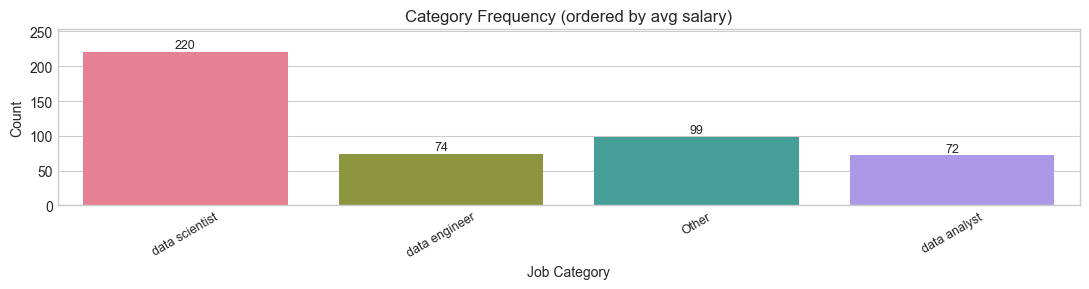

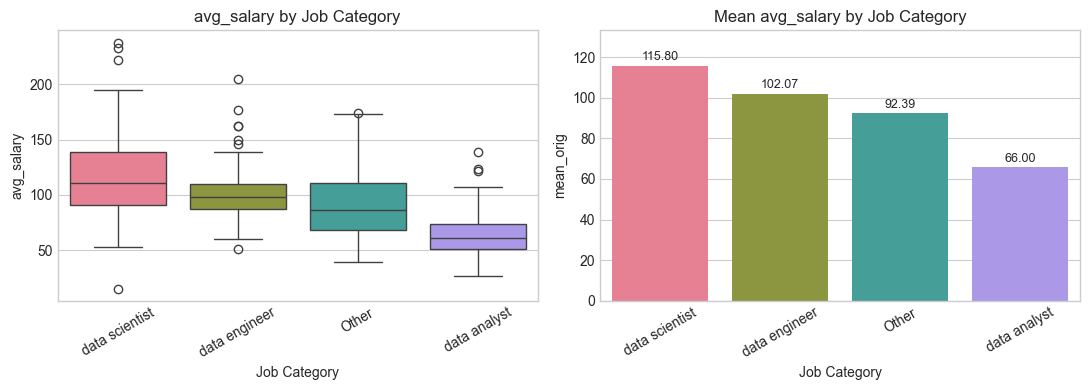

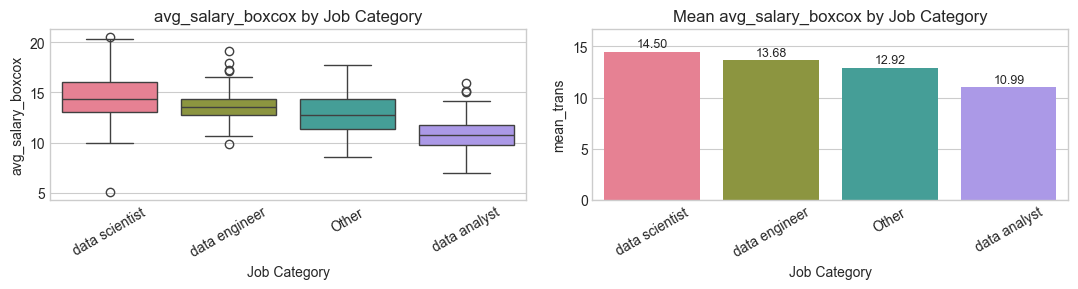

In [24]:
# Refresh the DataFrame list
all_dfs = [df_analysis, df_modeling_tree, df_modeling_linear]

# Define job category mapping
job_mapping = {
    "data scientist": "data scientist",
    "mle": "data scientist",       # Merged due to similar average salary
    "data engineer": "data engineer",
    "data analyst": "data analyst",
    "analyst": "Other",
    "scientist": "Other",
    "na": "Other"
}

# Apply mapping to all DataFrames
for i in range(len(all_dfs)):
    df = all_dfs[i]
    if "Job Category" in df.columns:
        df["Job Category"] = df["Job Category"].map(job_mapping)
    all_dfs[i] = df

# Reassign updated versions
df_analysis, df_modeling_tree, df_modeling_linear = all_dfs

# Display new distribution in df_analysis
print("✅ New 'Job Category' distribution in df_analysis:")
f.compare_categorical_with_targets(df_analysis, "Job Category", 'avg_salary', 'avg_salary_boxcox',image_name="salary_by_job_category")

### c. Number of competitors (`num_comp`)

This variable represents the number of competitor companies listed per job post. We hypothesized that greater competition might be associated with salary differences.

However, after analyzing the data, the ANOVA results showed **no statistically significant differences** in average salary across different values of `num_comp`:

- **Original salary**: F = 0.4076, p = 0.7476 ❌  
- **Transformed salary**: F = 0.5377, p = 0.6567 ❌

Given the lack of predictive power and interpretability, we decided to **remove this variable** from further analysis.



===== Comparison: 'num_comp' vs 'avg_salary' and 'avg_salary_boxcox' =====
Unique categories analyzed: 4

Descriptive statistics (sorted by original target):
          count        mean        std   min    max
num_comp                                           
1             8  108.000000  29.973798  68.5  153.0
3           148  102.777027  35.618218  37.5  237.5
2            24  102.375000  38.629581  50.0  181.0
0           284   99.788732  35.127221  15.5  232.5

ANOVA on avg_salary: F = 0.3515, p = 0.7881 → ❌
ANOVA on avg_salary_boxcox: F = 0.4672, p = 0.7053 → ❌


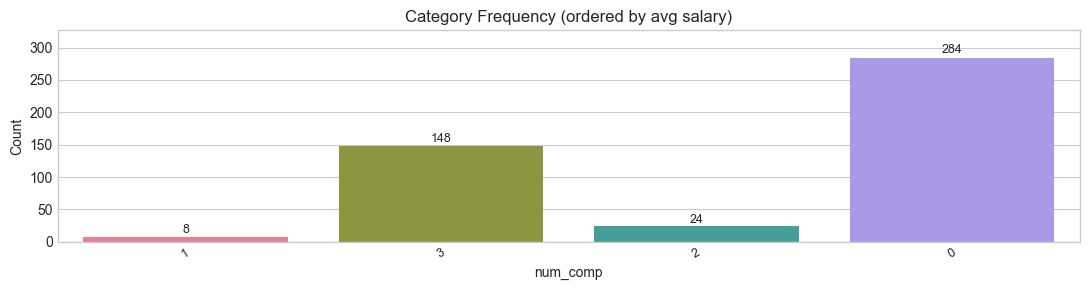

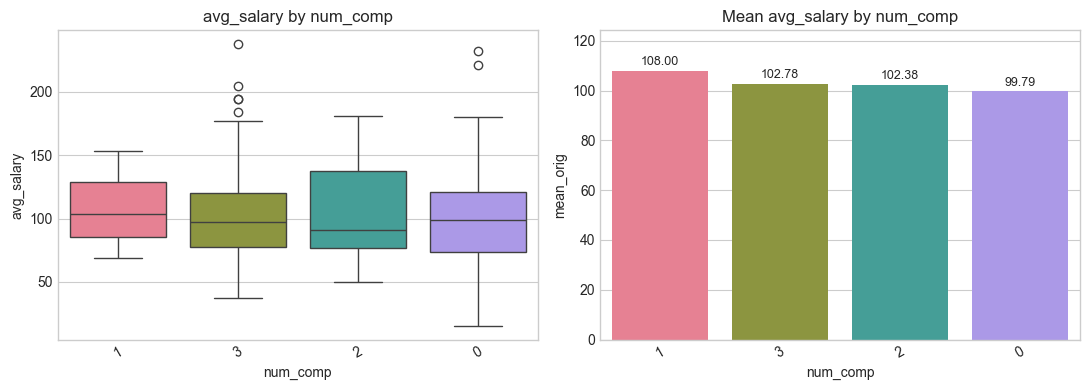

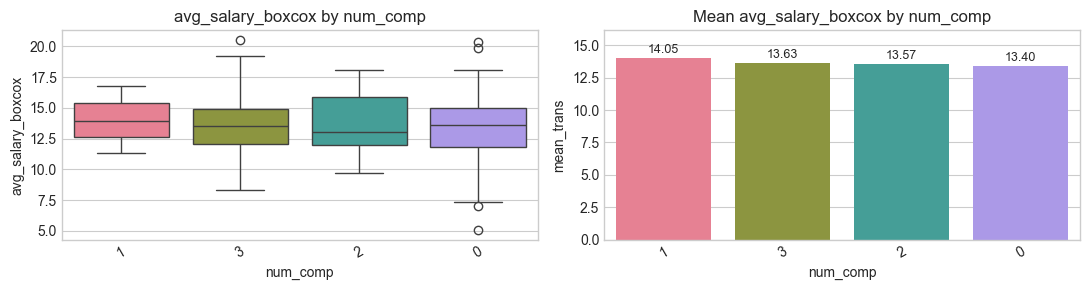

In [25]:
f.compare_categorical_with_targets(df_analysis, "num_comp", 'avg_salary', 'avg_salary_boxcox')

In [26]:
# Refresh the DataFrame list
all_dfs = [df_analysis, df_modeling_tree, df_modeling_linear]

# Drop 'num_comp' column if it exists
for i in range(len(all_dfs)):
    df = all_dfs[i]
    if "num_comp" in df.columns:
        df.drop(columns=["num_comp"], inplace=True)
    all_dfs[i] = df

# Reassign updated versions
df_analysis, df_modeling_tree, df_modeling_linear = all_dfs

print("✅ Column 'num_comp' has been dropped from all DataFrames.")


✅ Column 'num_comp' has been dropped from all DataFrames.


### d. `Type of ownership`

This feature initially showed a **statistically significant relationship** with average salary. For instance:

- `Subsidiary or Business Segment` and `Company - Public` offered the highest average salaries (~110K+).
- In contrast, `Nonprofit Organization` and `Hospital` had much lower average salaries (~70–75K).
- The `Company - Private` category, despite being the most frequent, had slightly lower salaries than public or subsidiary types.

However, several categories had **very low sample sizes** (e.g., `College / University`, `Government`, `Hospital`, and `Other`), making the variance in those groups less reliable.

🔄 To simplify the analysis and improve model robustness, we grouped **all low-frequency categories** under a common `"Other"` label.

This helps stabilize our statistical tests while keeping the most meaningful distinctions in the data.



===== Comparison: 'Type of ownership' vs 'avg_salary' and 'avg_salary_boxcox' =====
Unique categories analyzed: 8

Descriptive statistics (sorted by original target):
                                count        mean        std   min    max
Type of ownership                                                        
Subsidiary or Business Segment     25  113.920000  48.467274  37.5  232.5
Company - Public                  120  110.112500  32.510532  27.0  184.5
College / University                6  109.083333  19.213060  73.5  124.0
Company - Private                 260  100.359615  35.065335  15.5  237.5
Government                          9   82.777778  25.876040  40.0  120.0
other                               6   78.750000  27.661797  39.5  117.5
Nonprofit Organization             33   75.878788  23.736519  41.0  130.0
Hospital                            6   66.250000  15.920898  43.0   84.5

ANOVA on avg_salary: F = 5.9838, p = 0.0000 → ✅
ANOVA on avg_salary_boxcox: F = 6.3399, p =

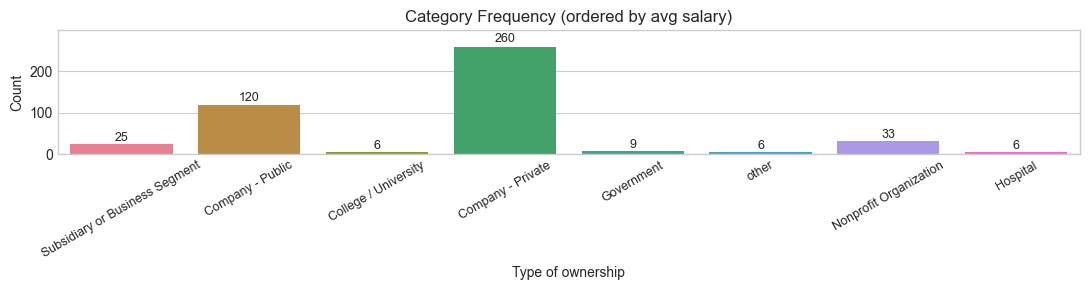

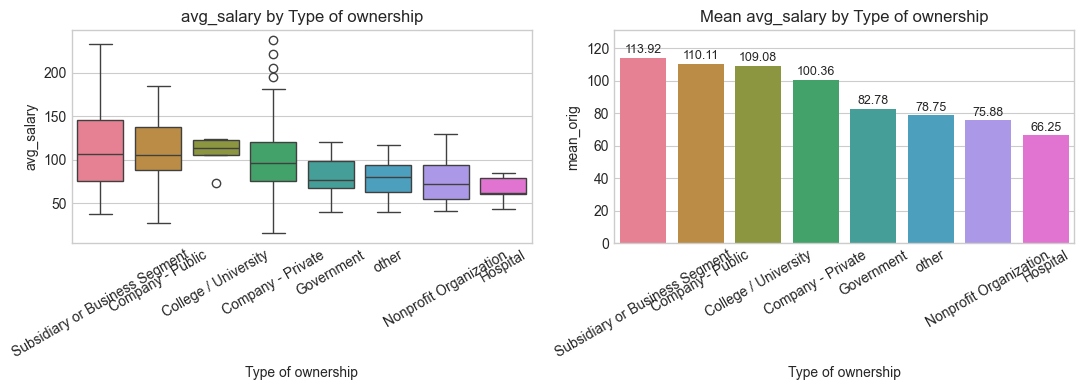

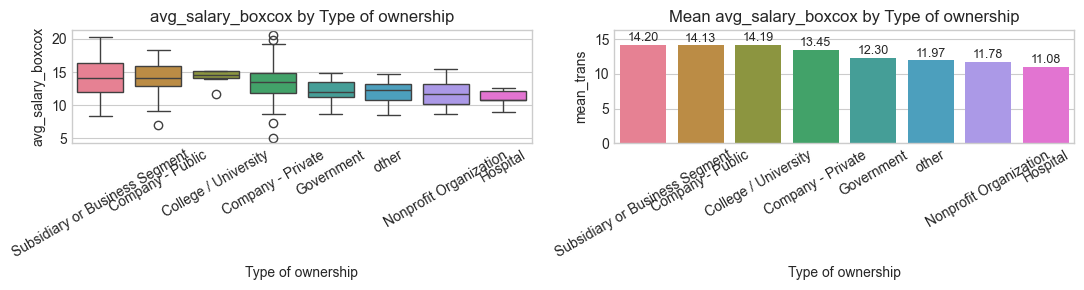

In [27]:
f.compare_categorical_with_targets(df_analysis, 'Type of ownership', 'avg_salary', 'avg_salary_boxcox')


Vemos que Type of ownership es un predictor significativo, pero la gran mayoria es de una sola categoria, lo cual es llamativo.Agrupemos aquellas con menos de 10 y veamos nuevamente

✅ 'Type of ownership' rare categories grouped under 'Other'.

===== Comparison: 'Type of ownership' vs 'avg_salary' and 'avg_salary_boxcox' =====
Unique categories analyzed: 5

Descriptive statistics (sorted by original target):
                                count        mean        std   min    max
Type of ownership                                                        
Subsidiary or Business Segment     25  113.920000  48.467274  37.5  232.5
Company - Public                  120  110.112500  32.510532  27.0  184.5
Company - Private                 260  100.359615  35.065335  15.5  237.5
Other                              27   84.055556  26.413623  39.5  124.0
Nonprofit Organization             33   75.878788  23.736519  41.0  130.0

ANOVA on avg_salary: F = 9.1735, p = 0.0000 → ✅
ANOVA on avg_salary_boxcox: F = 9.4914, p = 0.0000 → ✅


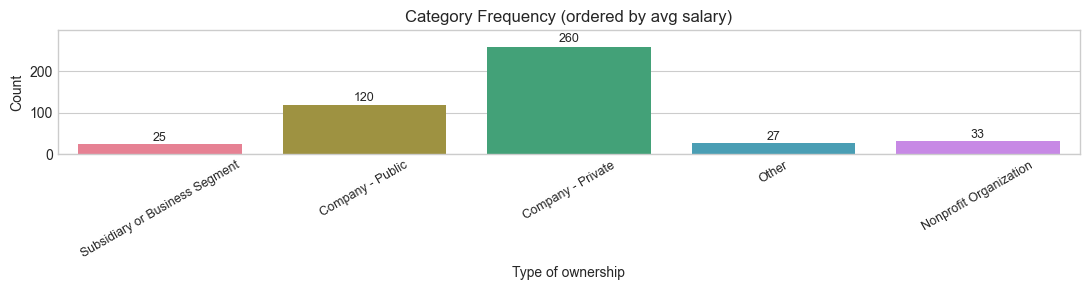

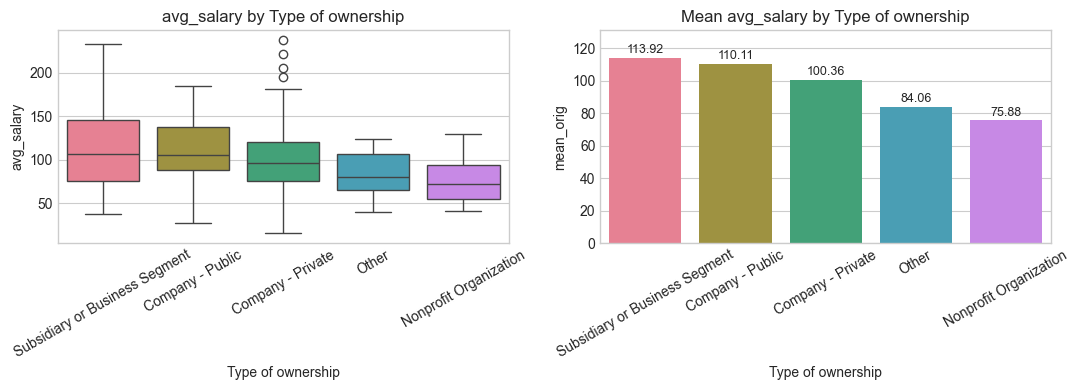

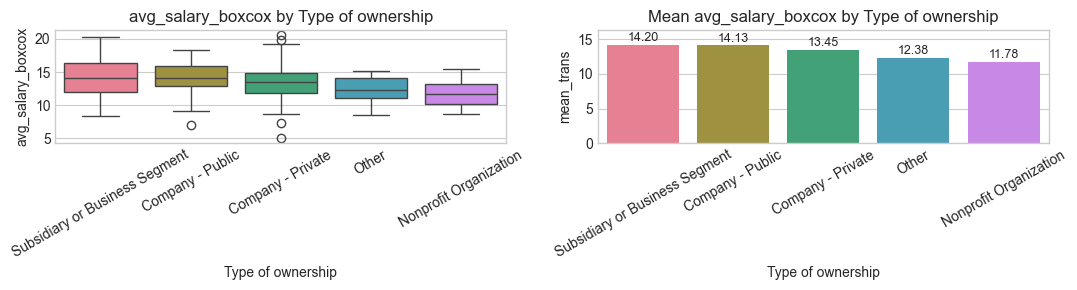

In [28]:
# Refresh the DataFrame list
all_dfs = [df_analysis, df_modeling_tree, df_modeling_linear]

# Identify ownership types with fewer than 10 occurrences in df_analysis
ownership_counts = df_analysis["Type of ownership"].value_counts()
to_group = ownership_counts[ownership_counts < 10].index

# Apply grouping to all DataFrames
for i in range(len(all_dfs)):
    df = all_dfs[i]
    if "Type of ownership" in df.columns:
        df["Type of ownership"] = df["Type of ownership"].apply(lambda x: "Other" if x in to_group else x)
    all_dfs[i] = df

# Reassign updated versions
df_analysis, df_modeling_tree, df_modeling_linear = all_dfs

# Show comparison in df_analysis only
print("✅ 'Type of ownership' rare categories grouped under 'Other'.")
f.compare_categorical_with_targets(df_analysis, "Type of ownership", "avg_salary", "avg_salary_boxcox")


Sigue siendo significativo, asi que lo dejamos

### e. Experience (`Merged Experience Category`)

To improve interpretability and simplify modeling, we **recategorized** the experience levels into broader, more meaningful groups:

This decision was guided by:

- The average salary distribution, where `Mid Level`, `Senior`, and `Some Experience` had similar upper-tier salary values.

- `Strong Experience` was positioned in between, so it was reclassified as semi-senior.

- `General Experience` aligned more closely with `Junior`, both in terms of salary and frequency.

The recategorized groups (senior, semi-senior, Junior, Entry Level, and Unknown) now show a clear gradient in average salary, maintaining both interpretability and predictive potential.


===== Comparison: 'Merged Experience Category' vs 'avg_salary' and 'avg_salary_boxcox' =====
Unique categories analyzed: 8

Descriptive statistics (sorted by original target):
                            count        mean        std   min    max
Merged Experience Category                                           
Mid Level                      12  116.625000  31.449183  61.5  172.0
Some Experience                69  112.673913  34.377428  47.5  184.5
Senior                         12  105.750000  30.841604  66.5  173.0
Strong Experience              31  104.096774  32.946274  27.0  194.5
General Experience            120  102.137500  36.943402  37.5  232.5
Junior                         57  100.631579  28.538121  48.0  177.0
Unknown                       135   95.900000  37.372510  15.5  237.5
Entry Level                    29   79.982759  27.236229  41.0  137.0

ANOVA on avg_salary: F = 3.4864, p = 0.0012 → ✅
ANOVA on avg_salary_boxcox: F = 3.8890, p = 0.0004 → ✅


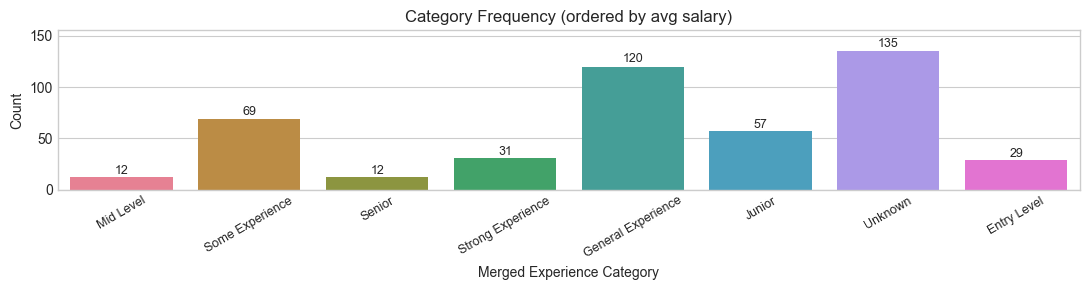

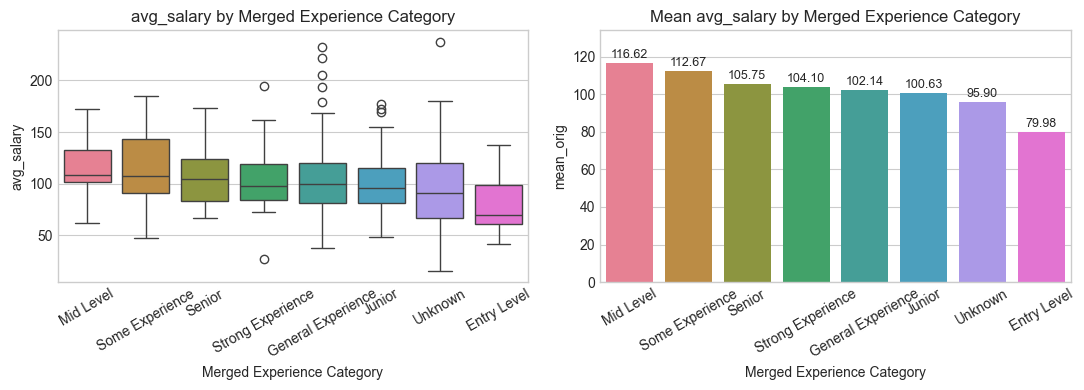

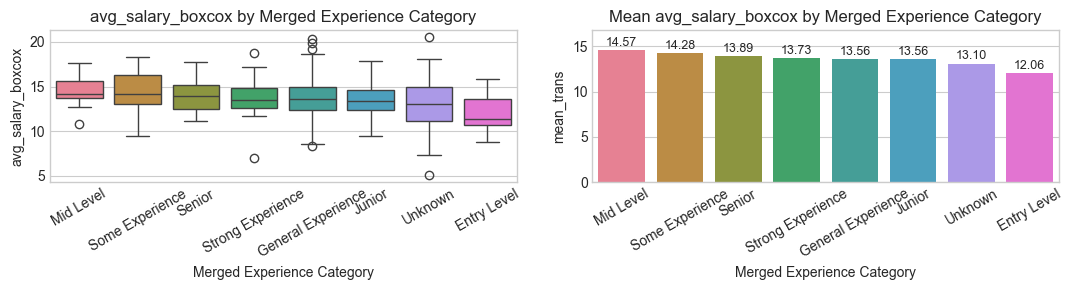

In [29]:
f.compare_categorical_with_targets(df_analysis, 'Merged Experience Category', 'avg_salary','avg_salary_boxcox')

✅ 'Merged Experience Category' recategorized:

===== Comparison: 'Merged Experience Category' vs 'avg_salary' and 'avg_salary_boxcox' =====
Unique categories analyzed: 5

Descriptive statistics (sorted by original target):
                            count        mean        std   min    max
Merged Experience Category                                           
senior                         93  112.290323  33.371209  47.5  184.5
semi-senior                    31  104.096774  32.946274  27.0  194.5
Junior                        177  101.652542  34.386538  37.5  232.5
Unknown                       135   95.900000  37.372510  15.5  237.5
Entry Level                    29   79.982759  27.236229  41.0  137.0

ANOVA on avg_salary: F = 5.9573, p = 0.0001 → ✅
ANOVA on avg_salary_boxcox: F = 6.7048, p = 0.0000 → ✅


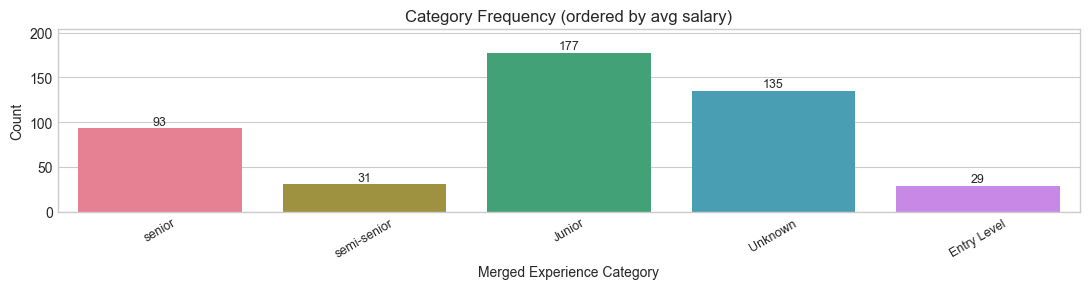

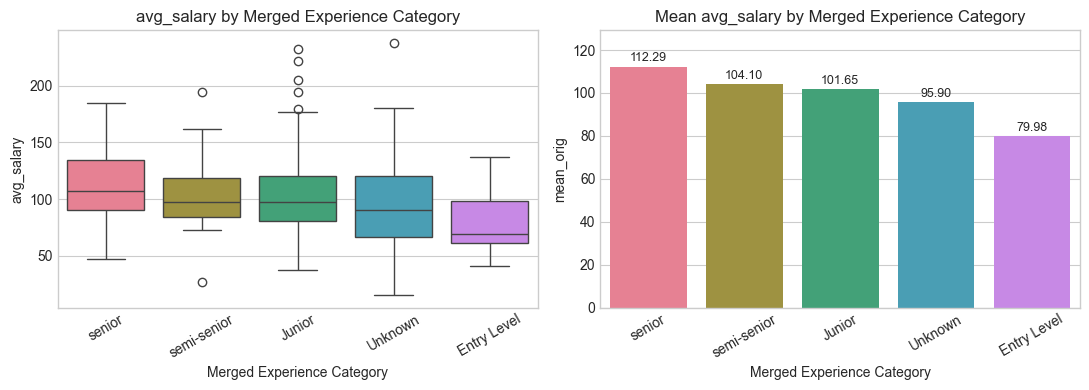

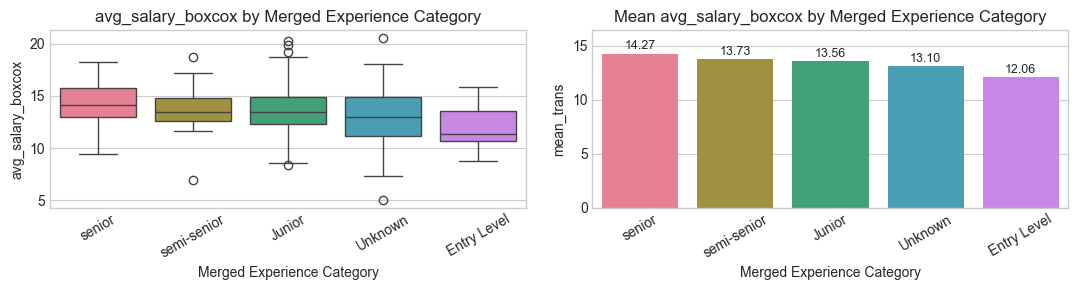

In [30]:
# Refresh the DataFrame list
all_dfs = [df_analysis, df_modeling_tree, df_modeling_linear]

# Define the recategorization mapping
experience_mapping = {
    "Mid Level": "senior",
    "Senior": "senior",
    "Some Experience": "senior",
    "Strong Experience": "semi-senior",
    "General Experience": "Junior"
}

# Apply mapping to all DataFrames
for i in range(len(all_dfs)):
    df = all_dfs[i]
    if "Merged Experience Category" in df.columns:
        df["Merged Experience Category"] = df["Merged Experience Category"].replace(experience_mapping)
    all_dfs[i] = df

# Reassign updated versions
df_analysis, df_modeling_tree, df_modeling_linear = all_dfs

# Compare in df_analysis
print("✅ 'Merged Experience Category' recategorized:")
f.compare_categorical_with_targets(df_analysis, "Merged Experience Category", "avg_salary", "avg_salary_boxcox",image_name="salary_by_experience")


### f. `Industry`

Initially, the `Industry` variable contained many categories, several of which had very few observations. Despite this, the ANOVA test was significant, suggesting that industry type does have an effect on average salary:

- Too many original categories → ANOVA still significant (p = 0.0037).

However, due to the sparsity of some categories, we decided to recategorize industries into broader and more interpretable groups, in order of both mean salary and count:

| Group                        | Mean Salary |
|------------------------------|-------------|
| **Tech / Innovation**        | 109.38      |
| **Health, Edu & Media**      | 105.23      |
| **Industry & Business**      | 97.04       |
| **Professional Services**    | 92.23       |
| **Public & Essential Svcs**  | 80.66       |

This mapping reduced the number of categories to just five while improving interpretability and maintaining statistical significance:

- After recategorization → fewer groups, better significance (p = 0.0000).



===== Comparison: 'Industry' vs 'avg_salary' and 'avg_salary_boxcox' =====
Unique categories analyzed: 12

Descriptive statistics (sorted by original target):
                              count        mean        std   min    max
Industry                                                               
Technology                      130  109.376923  38.214768  29.5  232.5
Education                        12  106.041667  30.695320  59.5  169.0
Health & Pharmaceuticals         89  105.314607  36.076023  41.0  221.5
Media & Entertainment            20  104.350000  31.462216  56.5  164.5
Retail & Consumer Services        9  102.388889  46.744504  51.5  179.5
Finance & Insurance              65   98.230769  36.478812  27.0  194.5
Other                            18   97.500000  24.070973  48.5  132.5
Manufacturing & Engineering      37   93.635135  24.203893  47.0  173.0
Professional Services            48   93.052083  36.647580  15.5  237.5
Energy & Utilities               10   84.200000 

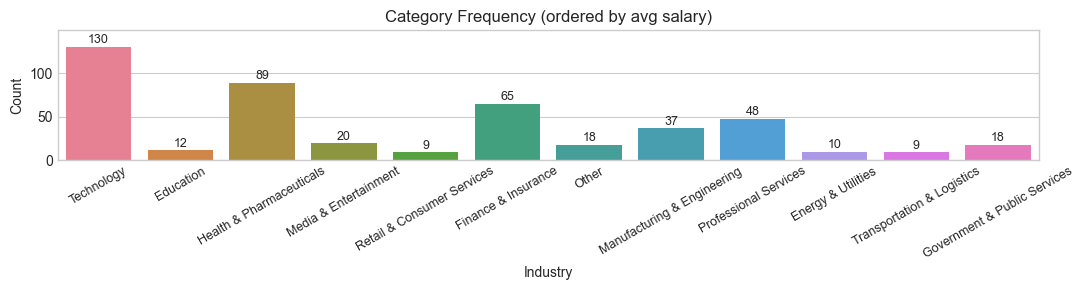

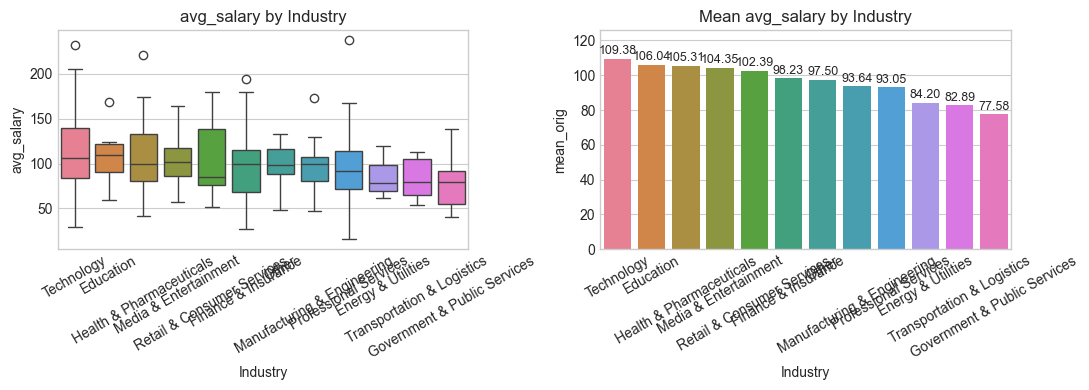

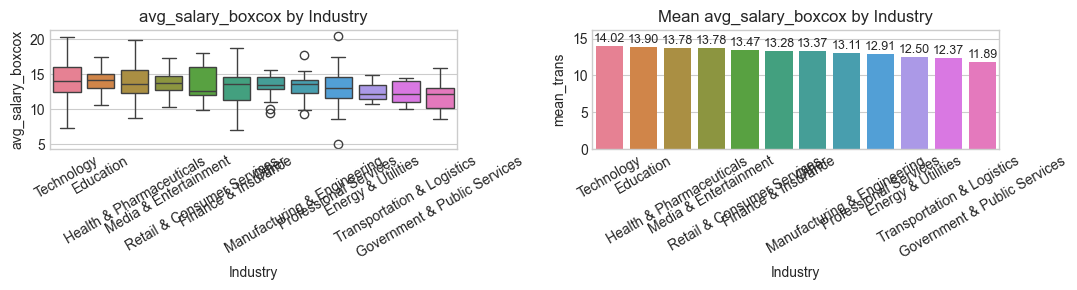

In [31]:
f.compare_categorical_with_targets(df_analysis, 'Industry', 'avg_salary',"avg_salary_boxcox")

Recategoricemos, tenemos muchas categorias y algunas con muy poca cantidad.

✅ 'Industry' recategorized into broader categories:

===== Comparison: 'Industry Recategorized' vs 'avg_salary' and 'avg_salary_boxcox' =====
Unique categories analyzed: 5

Descriptive statistics (sorted by original target):
                             count        mean        std   min    max
Industry Recategorized                                                
Tech / Innovation              130  109.376923  38.214768  29.5  232.5
Health, Education & Media      121  105.227273  34.608043  41.0  221.5
Industry & Business            111   97.036036  33.644378  27.0  194.5
Professional Services           66   94.265152  33.565575  15.5  237.5
Public & Essential Services     37   80.662162  22.619146  40.0  138.5

ANOVA on avg_salary: F = 6.5701, p = 0.0000 → ✅
ANOVA on avg_salary_boxcox: F = 6.3580, p = 0.0001 → ✅


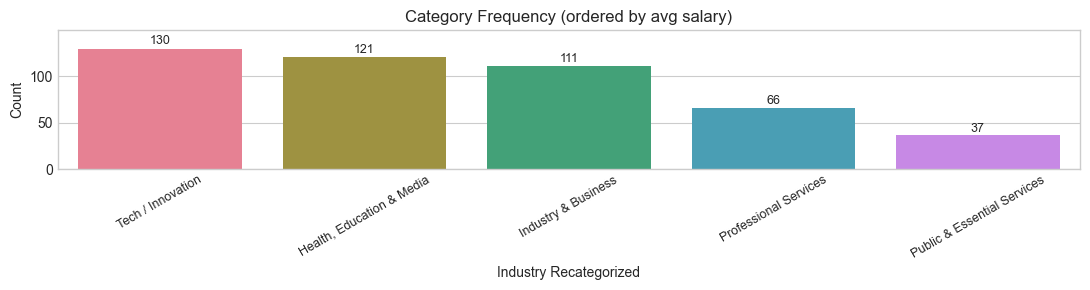

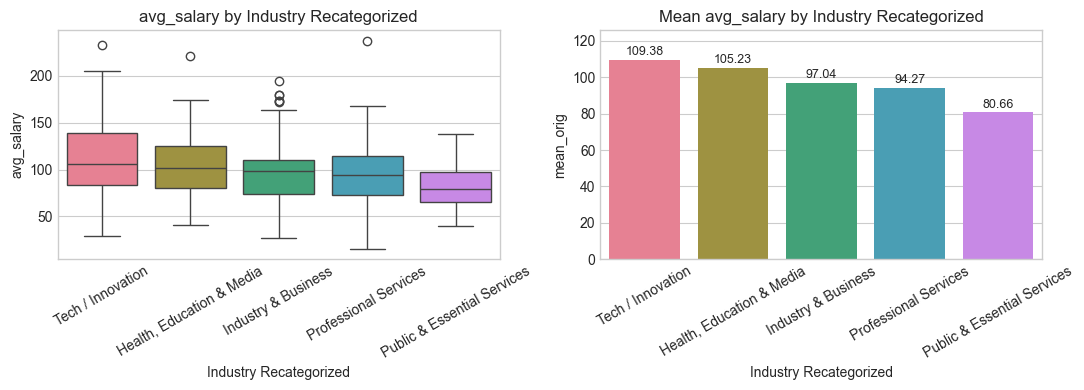

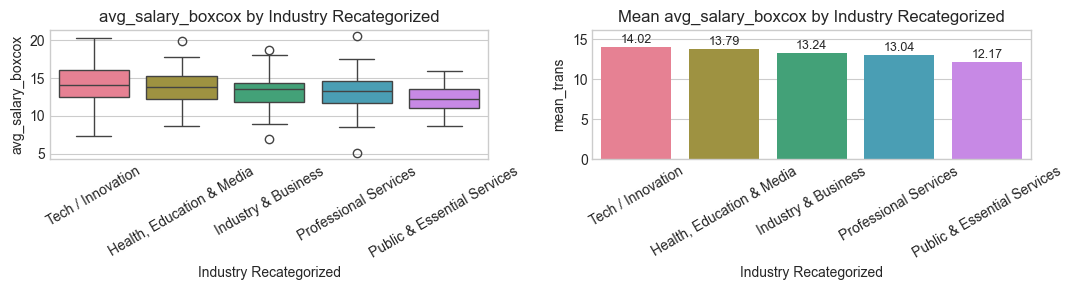

In [32]:
# Refresh the DataFrame list
all_dfs = [df_analysis, df_modeling_tree, df_modeling_linear]

# Define recategorization mapping
industry_mapping = {
    "Technology": "Tech / Innovation",
    "Unknown": "Tech / Innovation",
    
    "Health & Pharmaceuticals": "Health, Education & Media",
    "Education": "Health, Education & Media",
    "Media & Entertainment": "Health, Education & Media",
    
    "Finance & Insurance": "Industry & Business",
    "Retail & Consumer Services": "Industry & Business",
    "Real Estate & Construction": "Industry & Business",
    "Manufacturing & Engineering": "Industry & Business",
    
    "Professional Services": "Professional Services",
    "Other": "Professional Services",
    
    "Energy & Utilities": "Public & Essential Services",
    "Transportation & Logistics": "Public & Essential Services",
    "Government & Public Services": "Public & Essential Services",
    "Hospitality & Leisure": "Public & Essential Services"
}

# Apply mapping to all DataFrames
for i in range(len(all_dfs)):
    df = all_dfs[i]
    if "Industry" in df.columns:
        df["Industry Recategorized"] = df["Industry"].map(industry_mapping)
    all_dfs[i] = df

# Reassign updated versions
df_analysis, df_modeling_tree, df_modeling_linear = all_dfs

# Show comparison in df_analysis
print("✅ 'Industry' recategorized into broader categories:")
f.compare_categorical_with_targets(df_analysis, "Industry Recategorized", "avg_salary", "avg_salary_boxcox",image_name="salary_by_industry")


### g. `Sector`

The `Sector` variable originally included 10 categories. After grouping similar sectors, we reduced it to 5 broader and more interpretable groups. The ANOVA test remained significant, indicating sector continues to influence average salary:

- Before: 10 categories → ANOVA significant (p = 0.0143)
- After: 5 categories → better interpretability, still significant (p = 0.0009)

| Group                         | Count | Mean Salary | Summary                                       |
|------------------------------|--------|--------------|-----------------------------------------------|
| **Tech / Innovation**        | 126    | 109.35       | Highest salaries across all sectors.          |
| **Health, Education & Retail**| 109   | 104.90       | Strong salaries in service-related sectors.   |
| **Industry & Finance**       | 111    | 95.21        | Technical and financial roles, average pay.   |
| **Professional & Other Services**| 106| 93.34        | Varied services with moderate salaries.       |
| **Public Sector**            | 7      | 80.86        | Lowest salaries, concentrated in government.  |

⚠️ **Note**: This variable is conceptually similar to `Industry`. It’s important to check for redundancy and consider removing one during predictive modeling to avoid multicollinearity.



===== Comparison: 'Sector' vs 'avg_salary' and 'avg_salary_boxcox' =====
Unique categories analyzed: 10

Descriptive statistics (sorted by original target):
                              count        mean        std   min    max
Sector                                                                 
Technology                      126  109.349206  38.754523  29.5  232.5
Health & Pharmaceuticals         87  105.293103  36.138827  41.0  221.5
Retail                            8  104.750000  36.064426  51.5  163.5
Education                        14  102.535714  29.702023  59.5  169.0
Finance & Insurance              65   98.230769  36.478812  27.0  194.5
Other                            32   98.031250  24.211413  48.5  146.0
Manufacturing & Engineering      38   93.092105  24.108105  47.0  173.0
Professional Services            80   93.062500  36.247512  15.5  237.5
Government & Public Services      7   80.857143  22.001353  40.0  106.5
Energy & Utilities                8   80.750000  1

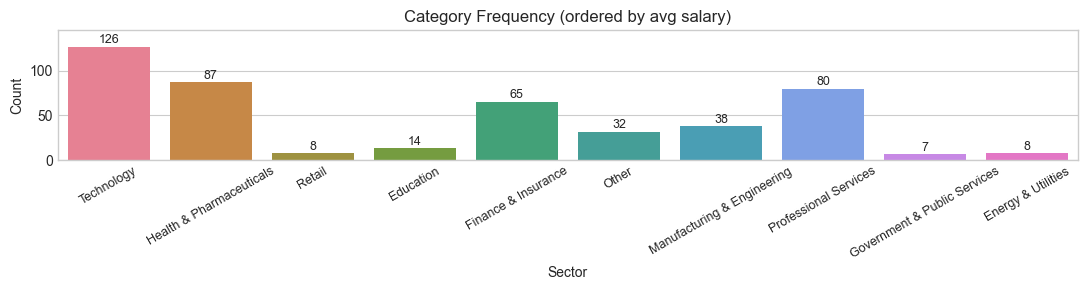

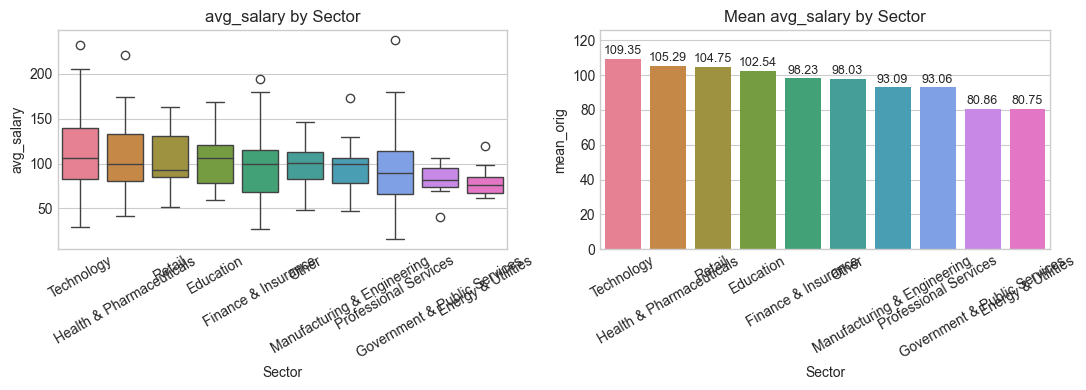

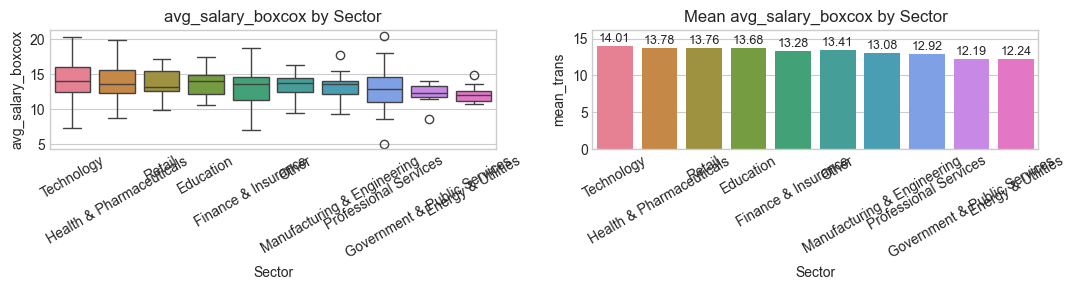

In [33]:
f.compare_categorical_with_targets(df_analysis, 'Sector', 'avg_salary',"avg_salary_boxcox")


✅ 'Sector' recategorized into broader categories:

===== Comparison: 'Sector' vs 'avg_salary' and 'avg_salary_boxcox' =====
Unique categories analyzed: 5

Descriptive statistics (sorted by original target):
                               count        mean        std   min    max
Sector                                                                  
Tech / Innovation                126  109.349206  38.754523  29.5  232.5
Health, Education & Retail       109  104.899083  35.090147  41.0  221.5
Industry & Finance               111   95.211712  31.864525  27.0  194.5
Professional & Other Services    112   94.482143  33.224999  15.5  237.5
Public Sector                      7   80.857143  22.001353  40.0  106.5

ANOVA on avg_salary: F = 4.4847, p = 0.0015 → ✅
ANOVA on avg_salary_boxcox: F = 4.1858, p = 0.0024 → ✅


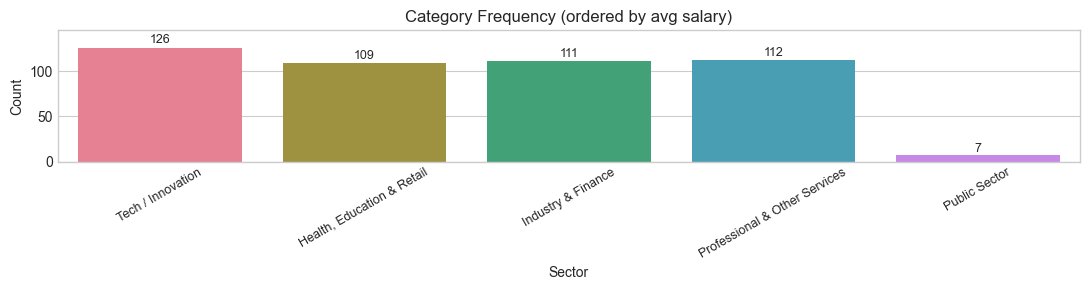

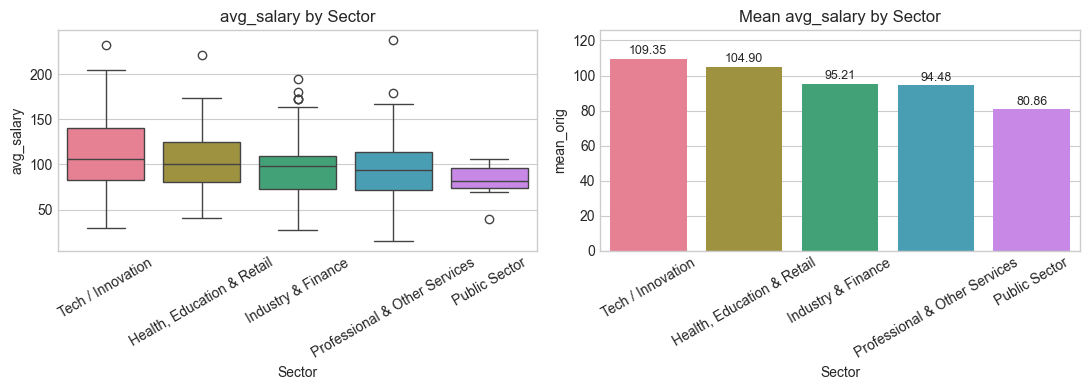

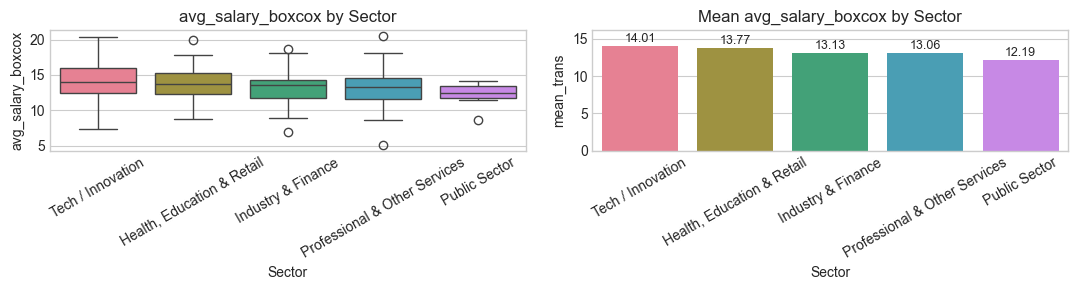

In [34]:
# Refresh the DataFrame list
all_dfs = [df_analysis, df_modeling_tree, df_modeling_linear]

# Define sector recategorization mapping
sector_mapping = {
    "Technology": "Tech / Innovation",
    
    "Health & Pharmaceuticals": "Health, Education & Retail",
    "Education": "Health, Education & Retail",
    "Retail": "Health, Education & Retail",
    
    "Finance & Insurance": "Industry & Finance",
    "Manufacturing & Engineering": "Industry & Finance",
    "Energy & Utilities": "Industry & Finance",
    
    "Professional Services": "Professional & Other Services",
    "Other": "Professional & Other Services",
    
    "Government & Public Services": "Public Sector"
}

# Apply mapping to all DataFrames
for i in range(len(all_dfs)):
    df = all_dfs[i]
    if "Sector" in df.columns:
        df["Sector"] = df["Sector"].map(sector_mapping)
    all_dfs[i] = df

# Reassign updated versions
df_analysis, df_modeling_tree, df_modeling_linear = all_dfs

# Show comparison in df_analysis
print("✅ 'Sector' recategorized into broader categories:")
f.compare_categorical_with_targets(df_analysis, "Sector", "avg_salary", "avg_salary_boxcox")


### h. `Revenue`

Initially, the `Revenue` variable had 12 categories, many with very small sample sizes. ANOVA tests showed a significant relationship between revenue and average salary:

- Too many original categories → ANOVA still significant (p = 0.0002).

To improve interpretability, companies were grouped into 5 broader revenue tiers based on their annual income:

| Group                         | Count | Mean Salary | Summary                                      |
|------------------------------|--------|--------------|----------------------------------------------|
| **Corporación Multinacional**| 69     | 112.32       | Highest salaries, typical of large global firms. |
| **Desconocido / No aplica**  | 128    | 106.42       | High salaries, but unclear revenue info.     |
| **Gran Empresa**             | 77     | 98.23        | Large companies with solid salary levels.    |
| **Micro y Pequeña Empresa**  | 64     | 95.48        | Small firms offering moderately lower salaries. |
| **Mediana Empresa**          | 121    | 92.52        | Mid-size firms with the lowest average salaries. |

This new grouping maintained statistical significance while reducing noise:

- After recategorization → fewer groups, still significant (p = 0.0008).



===== Comparison: 'Revenue' vs 'avg_salary' and 'avg_salary_boxcox' =====
Unique categories analyzed: 12

Descriptive statistics (sorted by original target):
                                  count        mean        std   min    max
Revenue                                                                    
$1 to $5 million (USD)                5  115.800000  18.209201  94.5  140.5
$5 to $10 million (USD)              12  114.750000  29.393490  74.0  167.5
$10+ billion (USD)                   69  112.318841  36.124272  50.0  194.5
Unknown / Non-Applicable            133  106.706767  37.763675  40.0  237.5
$1 to $2 billion (USD)               39  104.128205  30.626940  60.0  173.0
$50 to $100 million (USD)            30   97.650000  40.924268  43.0  205.0
$10 to $25 million (USD)             21   95.761905  33.594129  47.0  181.0
$2 to $5 billion (USD)               26   92.250000  34.599783  27.0  162.5
$5 to $10 billion (USD)              12   92.000000  36.828225  47.5  162.0
$100 

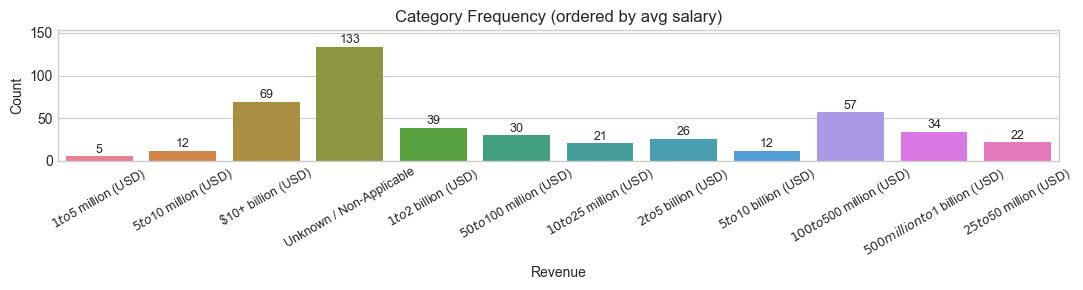

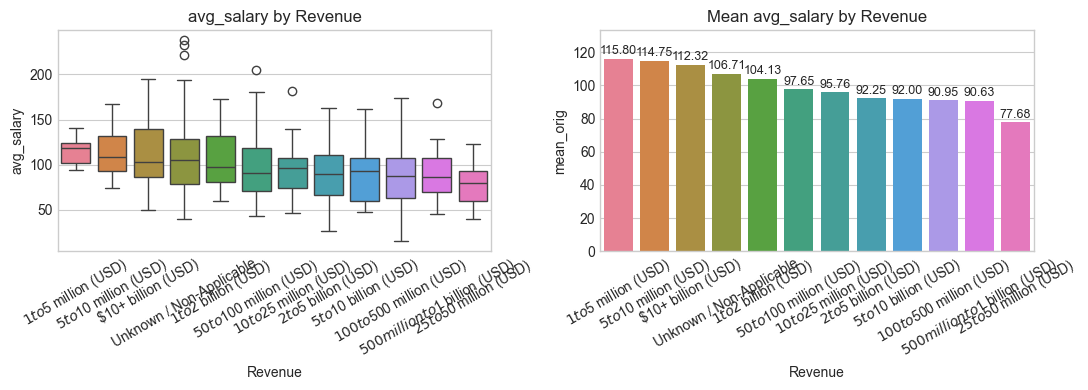

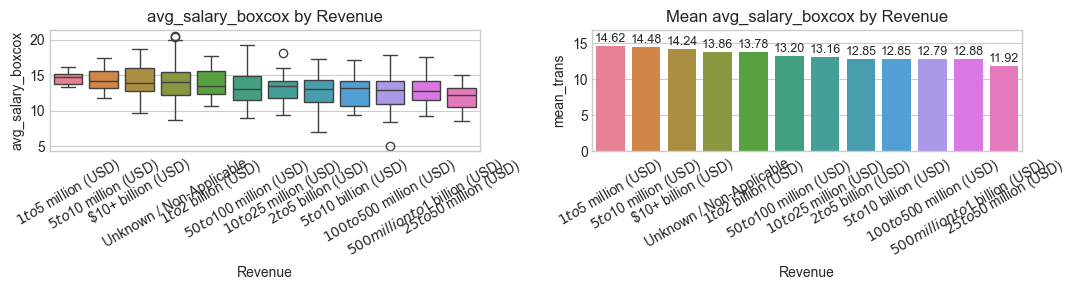

In [35]:
f.compare_categorical_with_targets(df_analysis, 'Revenue', 'avg_salary',"avg_salary_boxcox")


✅ 'Revenue' recategorized into grouped company tiers:

===== Comparison: 'Revenue_recategorized' vs 'avg_salary' and 'avg_salary_boxcox' =====
Unique categories analyzed: 5

Descriptive statistics (sorted by original target):
                             count        mean        std   min    max
Revenue_recategorized                                                 
Corporation / Multinational     69  112.318841  36.124272  50.0  194.5
Unknown / N/A                  134  106.787313  37.632991  40.0  237.5
Large Business                  77   98.227273  33.095709  27.0  173.0
Micro / Small Business          64   95.476562  30.849279  39.5  181.0
Mid-size Business              121   92.520661  33.507984  15.5  205.0

ANOVA on avg_salary: F = 5.0907, p = 0.0005 → ✅
ANOVA on avg_salary_boxcox: F = 5.0930, p = 0.0005 → ✅


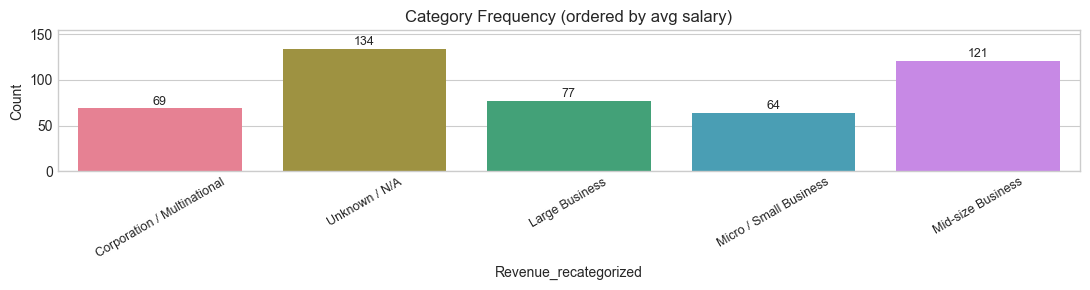

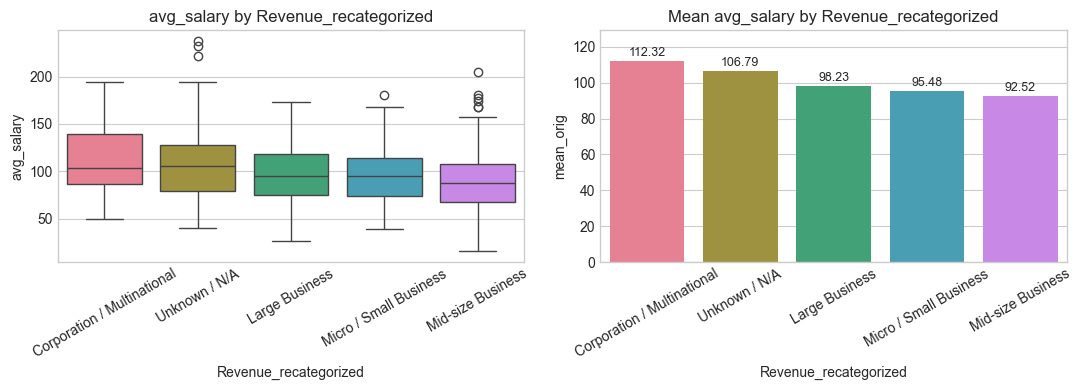

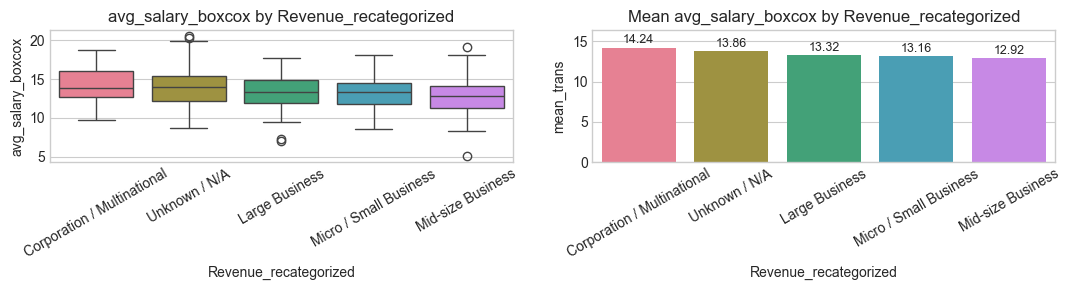

In [36]:
# Refresh the DataFrame list
all_dfs = [df_analysis, df_modeling_tree, df_modeling_linear]

# Define revenue recategorization mapping
revenue_mapping = {
    "Less than $1 million (USD)": "Micro / Small Business",
    "$1 to $5 million (USD)": "Micro / Small Business",
    "$5 to $10 million (USD)": "Micro / Small Business",
    "$10 to $25 million (USD)": "Micro / Small Business",
    "$25 to $50 million (USD)": "Micro / Small Business",
    
    "$50 to $100 million (USD)": "Mid-size Business",
    "$100 to $500 million (USD)": "Mid-size Business",
    "$500 million to $1 billion (USD)": "Mid-size Business",
    
    "$1 to $2 billion (USD)": "Large Business",
    "$2 to $5 billion (USD)": "Large Business",
    "$5 to $10 billion (USD)": "Large Business",
    
    "$10+ billion (USD)": "Corporation / Multinational",
    
    "Unknown": "Unknown / N/A",
    "Unknown / Non-Applicable": "Unknown / N/A"
}

# Apply mapping to all DataFrames
for i in range(len(all_dfs)):
    df = all_dfs[i]
    if "Revenue" in df.columns:
        df["Revenue_recategorized"] = df["Revenue"].map(revenue_mapping)
    all_dfs[i] = df

# Reassign updated versions
df_analysis, df_modeling_tree, df_modeling_linear = all_dfs

# Show comparison in df_analysis
print("✅ 'Revenue' recategorized into grouped company tiers:")
f.compare_categorical_with_targets(df_analysis, "Revenue_recategorized", "avg_salary", "avg_salary_boxcox")


### i. State (`job_state`)

The `job_state` variable originally had 22 categories, many with limited data. ANOVA results confirmed that state has a significant impact on salary:

- Too many original categories → ANOVA still significant (p = 0.0000).

To improve clarity, states were grouped into individual high-sample states or broader regions:

| Group             | Count | Mean Salary | Summary                                      |
|------------------|--------|--------------|----------------------------------------------|
| **CA**           | 97     | 123.79       | Highest salaries, clearly above all others.  |
| **IL**           | 21     | 105.55       | High-paying state in the Midwest.            |
| **MA**           | 56     | 104.63       | Top-paying state in the Northeast.           |
| **NY**           | 46     | 100.01       | Strong salaries in a key urban hub.          |
| **MD**           | 22     | 98.95        | Slightly above-average salaries.             |
| **VA**           | 30     | 97.67        | Comparable to MD, mid-to-high range.         |
| **Northeast Other**| 35   | 95.77        | Other NE states, near national average.      |
| **South Other**  | 71     | 87.76        | Wide range, generally lower salaries.        |
| **West Other**   | 41     | 84.91        | Lower salaries across western states.        |
| **Midwest Other**| 40     | 84.63        | Lowest average salaries in grouped states.   |

This new categorization improved both interpretability and statistical strength:

- After recategorization → fewer, clearer groups, stronger significance (p = 0.0000).



===== Comparison: 'job_state' vs 'avg_salary' and 'avg_salary_boxcox' =====
Unique categories analyzed: 22

Descriptive statistics (sorted by original target):
           count        mean        std   min    max
job_state                                           
CA            97  123.587629  39.536508  47.5  232.5
DC             9  110.166667  56.884203  50.0  237.5
MA            60  105.816667  31.388215  47.5  172.0
IL            21  105.547619  37.885982  52.5  194.5
NJ            13  102.346154  39.104766  56.5  173.0
NY            47  100.234043  34.500449  15.5  172.0
NC            11   99.181818  21.662494  65.5  134.0
MD            22   98.954545  22.683594  62.0  147.5
VA            30   97.666667  20.605629  61.5  147.0
PA            19   93.421053  31.600045  41.0  155.0
TX            17   93.235294  28.468249  43.0  149.5
OH             9   91.555556  20.123749  45.5  110.5
WA            15   90.200000  34.948840  44.5  184.5
TN             7   89.571429  28.464054  27.

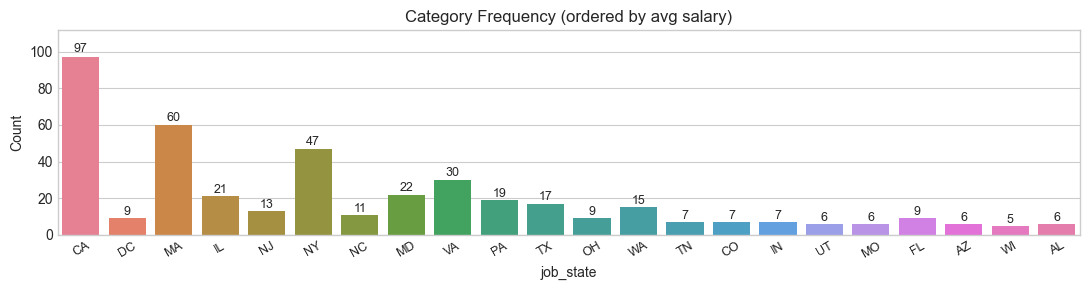

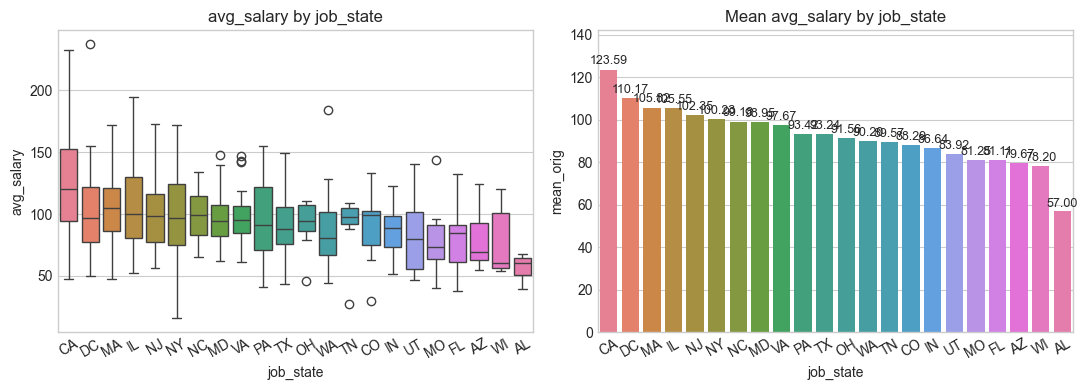

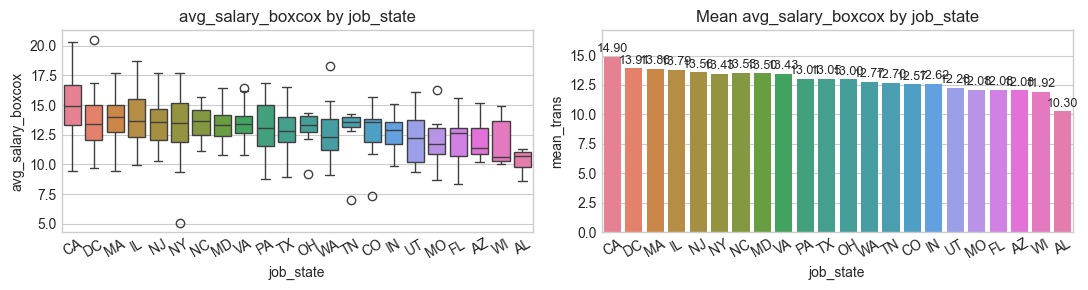

In [37]:
f.compare_categorical_with_targets(df_analysis, 'job_state', 'avg_salary',"avg_salary_boxcox")


In [38]:
# Refresh the DataFrame list
all_dfs = [df_analysis, df_modeling_tree, df_modeling_linear]

# Define state-to-region mapping
state_group_mapping = {
    # Individual states with sufficient data
    "CA": "CA",
    "IL": "IL",
    "MA": "MA",
    "NY": "NY",
    "MD": "MD",
    "VA": "VA",
    
    # West Region
    "OR": "West Other",
    "WA": "West Other",
    "CO": "West Other",
    "AZ": "West Other",
    "NM": "West Other",
    "UT": "West Other",
    "ID": "West Other",
    
    # Northeast Region
    "PA": "Northeast Other",
    "CT": "Northeast Other",
    "RI": "Northeast Other",
    "NJ": "Northeast Other",
    
    # Midwest Region
    "OH": "Midwest Other",
    "IN": "Midwest Other",
    "IA": "Midwest Other",
    "KS": "Midwest Other",
    "MN": "Midwest Other",
    "MO": "Midwest Other",
    "WI": "Midwest Other",
    "NE": "Midwest Other",
    "MI": "Midwest Other",
    
    # South Region
    "DC": "South Other",
    "NC": "South Other",
    "TX": "South Other",
    "FL": "South Other",
    "GA": "South Other",
    "AL": "South Other",
    "SC": "South Other",
    "LA": "South Other",
    "KY": "South Other",
    "TN": "South Other",
    "DE": "South Other",
    
    'AK': 'West Other',
    'HI': 'West Other',
    'NV': 'West Other',
    'MT': 'West Other',
    'WY': 'West Other',

    'ME': 'Northeast Other',
    'NH': 'Northeast Other',
    'VT': 'Northeast Other',

    'AR': 'South Other',
    'MS': 'South Other',
    'OK': 'South Other',
    'WV': 'South Other',

    'ND': 'Midwest Other',
    'SD': 'Midwest Other'
}

# Apply fix and mapping to all DataFrames
for i in range(len(all_dfs)):
    df = all_dfs[i]

    # Fix common issue where 'Los Angeles' is parsed as a state
    df.loc[df["job_state"] == "Los Angeles", "job_state"] = "CA"

    # Apply regional mapping
    df["Region"] = df["job_state"].map(state_group_mapping).fillna("Other")

    all_dfs[i] = df

# Reassign updated versions
df_analysis, df_modeling_tree, df_modeling_linear = all_dfs

print("✅ 'job_state' column standardized and mapped to broader regions as 'Region'.")


✅ 'job_state' column standardized and mapped to broader regions as 'Region'.


✅ Cleaned job_state values: ['NM' 'MD' 'FL' 'WA' 'NY' 'TX' 'CA' 'VA' 'MA' 'NJ' 'CO' 'IL' 'KY' 'OR'
 'CT' 'MI' 'DC' 'OH' 'AL' 'MO' 'PA' 'GA' 'IN' 'LA' 'WI' 'NC' 'AZ' 'NE'
 'MN' 'UT' 'TN' 'DE' 'ID' 'RI' 'IA' 'SC' 'KS']
🚨 Unmapped states: []
✅ Final grouped state mapping applied:

===== Comparison: 'job_state_grouped' vs 'avg_salary' and 'avg_salary_boxcox' =====
Unique categories analyzed: 10

Descriptive statistics (sorted by original target):
                   count        mean        std   min    max
job_state_grouped                                           
CA                    98  123.423469  39.365742  47.5  232.5
MA                    60  105.816667  31.388215  47.5  172.0
IL                    21  105.547619  37.885982  52.5  194.5
NY                    47  100.234043  34.500449  15.5  172.0
MD                    22   98.954545  22.683594  62.0  147.5
VA                    30   97.666667  20.605629  61.5  147.0
Northeast Other       35   95.771429  33.543068  41.0  173.0
Sout

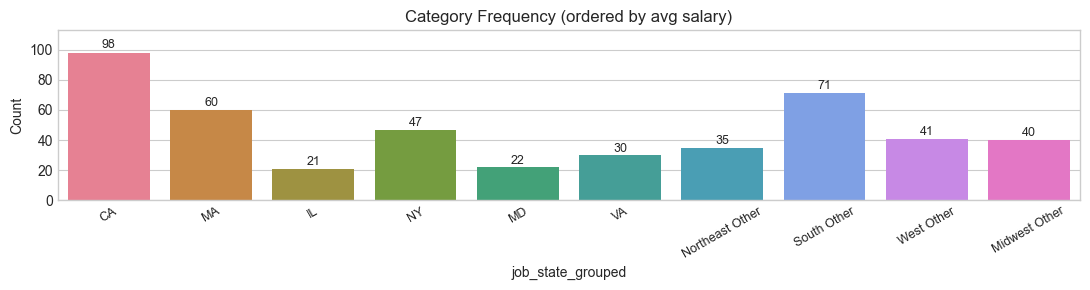

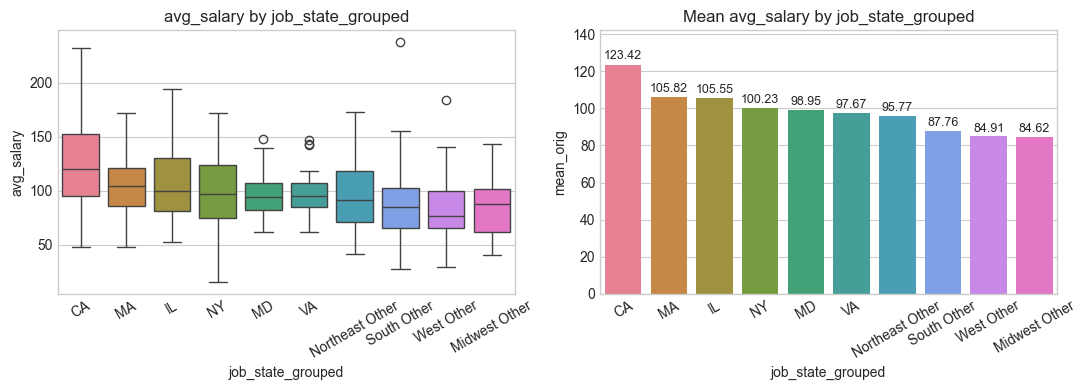

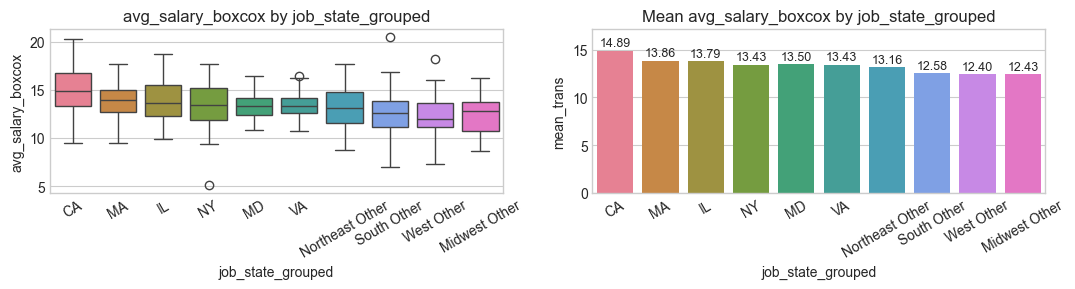

In [39]:
# Refresh DataFrame list
all_dfs = [df_analysis, df_modeling_tree, df_modeling_linear]

# Apply cleaning and mapping to all DataFrames
for i in range(len(all_dfs)):
    df = all_dfs[i]

    # 1. Remove leading/trailing whitespace
    df["job_state"] = df["job_state"].str.strip()

    # 2. Fix common parsing error for Los Angeles
    df.loc[df["job_state"] == "Los Angeles", "job_state"] = "CA"

    # 3. Create grouped region column with fallback to 'Other'
    df["job_state_grouped"] = df["job_state"].map(lambda x: state_group_mapping.get(x, "Other"))

    # Optional: display unmapped states (for review)
    if i == 0:  # Only display for df_analysis
        print("✅ Cleaned job_state values:", df["job_state"].unique())
        unmapped_states = df[~df["job_state"].isin(state_group_mapping.keys())]["job_state"].unique()
        print("🚨 Unmapped states:", unmapped_states)

    all_dfs[i] = df

# Reassign updated DataFrames
df_analysis, df_modeling_tree, df_modeling_linear = all_dfs

# Summary plot (df_analysis only)
print("✅ Final grouped state mapping applied:")
f.compare_categorical_with_targets(df_analysis, "job_state_grouped", "avg_salary", "avg_salary_boxcox",image_name="salary_by_state")


## 5. Binary variables analysis

To assess the influence of specific tools on salary, we used the `analyze_binary_vs_target` function, which evaluates the relationship between a binary variable (e.g., whether a tool is mentioned or not) and a numerical target variable (the salary).

This function uses an independent samples T-test, which determines whether the means of two independent groups are statistically different from each other. In this case, it compares the average salary of job listings that mention a tool (1) versus those that don’t (0). The test assumes unequal variances and returns a p-value; if p < 0.05, we consider the difference statistically significant.

#### Key Insights

The first chart shows the most mentioned tools in job descriptions, highlighting in green those with a statistically significant relationship with salary. While tools like Excel, SQL, and same_state appear very frequently, they surprisingly do not correspond to higher salaries.

To better understand the impact of Python-related tools, we separated general Python knowledge (python_yn) from specific Python tools like scikit-learn, keras, pandas, and tensorflow. We created a new binary variable python_tool_yn to reflect this. The results show that knowledge of specific Python tools is more strongly associated with higher salaries than general Python mentions.

We also grouped related technologies into cloud_or_big_data_yn (including AWS, Docker, Spark, and Hadoop), which also showed a modest positive salary impact.

The second and third charts display the mean salary and standard deviation for tools with significant influence. This helps to prioritize which technologies could be more beneficial for professionals aiming for higher-paying data role

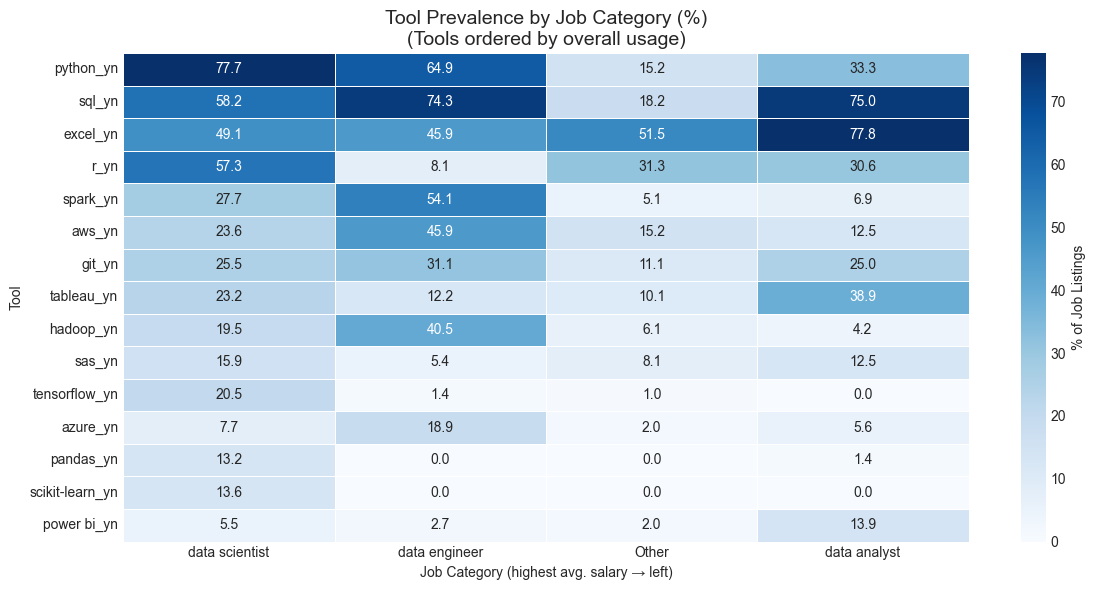

In [40]:
df_binary = df_analysis.loc[:, df_analysis.nunique() == 2]

a = f.plot_tool_heatmap_by_job_category(df_analysis, df_binary, target_col='avg_salary', min_usage=25, show_plot=True)

--------------------------------------------------
--------------------------------------------------

===== Analysis of python_yn vs avg_salary_boxcox (Binary - Transformed) =====

Category Counts:
python_yn
1    258
0    207
Name: count, dtype: int64

T-test on avg_salary_boxcox: Statistic = 6.3472, p-value = 0.0000
✅ python_yn is a significant predictor of avg_salary_boxcox.

Mean Difference (original target): 19.07
Std. Deviation of Difference (original target): 3.18


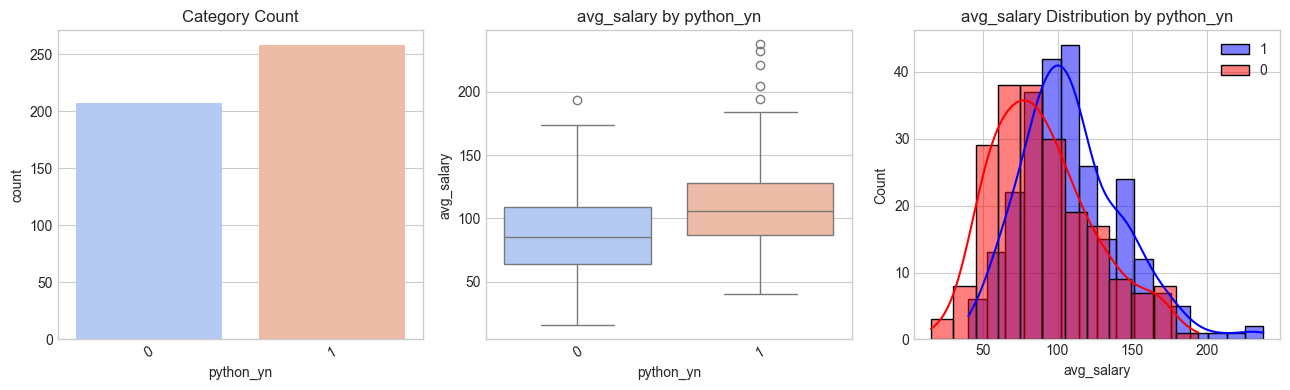

--------------------------------------------------
--------------------------------------------------

===== Analysis of sql_yn vs avg_salary_boxcox (Binary - Transformed) =====

Category Counts:
sql_yn
1    255
0    210
Name: count, dtype: int64

T-test on avg_salary_boxcox: Statistic = 0.0046, p-value = 0.9963
❌ sql_yn does not show a statistically significant relationship with avg_salary_boxcox.
--------------------------------------------------
--------------------------------------------------

===== Analysis of excel_yn vs avg_salary_boxcox (Binary - Transformed) =====

Category Counts:
excel_yn
1    249
0    216
Name: count, dtype: int64

T-test on avg_salary_boxcox: Statistic = -1.8994, p-value = 0.0581
❌ excel_yn does not show a statistically significant relationship with avg_salary_boxcox.
--------------------------------------------------
--------------------------------------------------

===== Analysis of tableau_yn vs avg_salary_boxcox (Binary - Transformed) =====

Catego

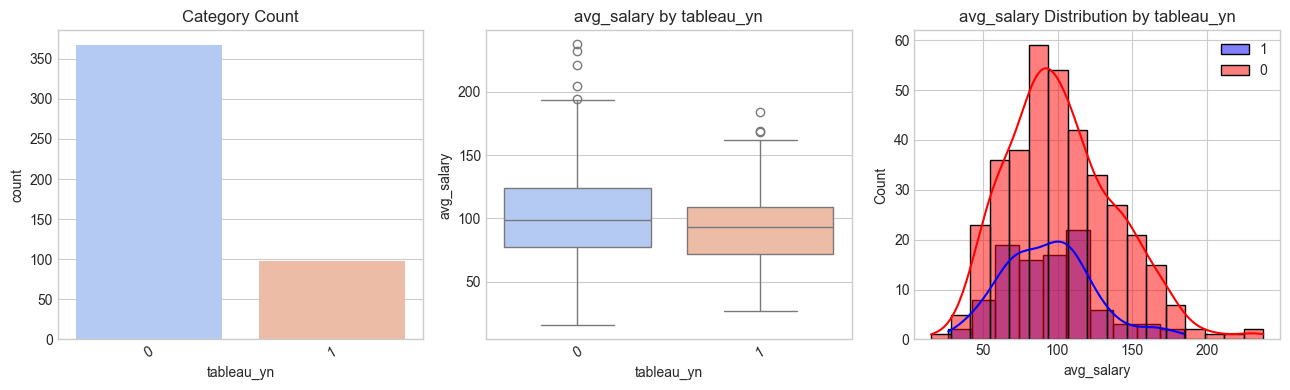

--------------------------------------------------
--------------------------------------------------

===== Analysis of power bi_yn vs avg_salary_boxcox (Binary - Transformed) =====

Category Counts:
power bi_yn
0    439
1     26
Name: count, dtype: int64

T-test on avg_salary_boxcox: Statistic = -1.3084, p-value = 0.2010
❌ power bi_yn does not show a statistically significant relationship with avg_salary_boxcox.
--------------------------------------------------
--------------------------------------------------

===== Analysis of sas_yn vs avg_salary_boxcox (Binary - Transformed) =====

Category Counts:
sas_yn
0    409
1     56
Name: count, dtype: int64

T-test on avg_salary_boxcox: Statistic = 0.1456, p-value = 0.8846
❌ sas_yn does not show a statistically significant relationship with avg_salary_boxcox.
--------------------------------------------------
--------------------------------------------------

===== Analysis of hadoop_yn vs avg_salary_boxcox (Binary - Transformed) =====

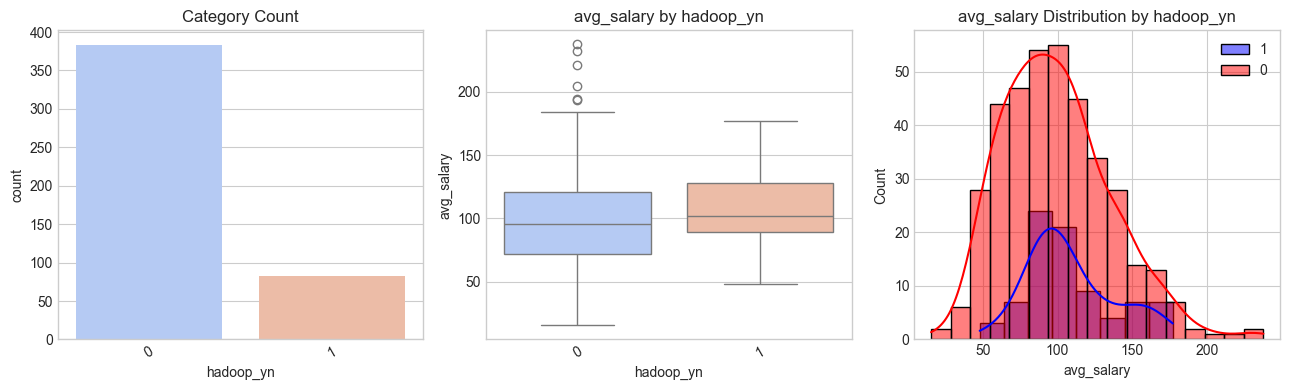

--------------------------------------------------
--------------------------------------------------

===== Analysis of spark_yn vs avg_salary_boxcox (Binary - Transformed) =====

Category Counts:
spark_yn
0    354
1    111
Name: count, dtype: int64

T-test on avg_salary_boxcox: Statistic = 4.2909, p-value = 0.0000
✅ spark_yn is a significant predictor of avg_salary_boxcox.

Mean Difference (original target): 13.17
Std. Deviation of Difference (original target): 3.50


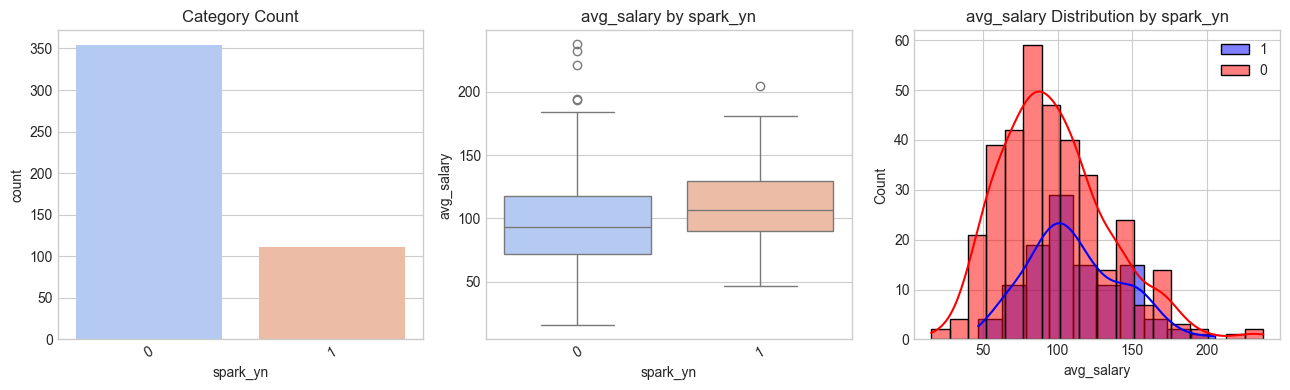

--------------------------------------------------
--------------------------------------------------

===== Analysis of tensorflow_yn vs avg_salary_boxcox (Binary - Transformed) =====

Category Counts:
tensorflow_yn
0    418
1     47
Name: count, dtype: int64

T-test on avg_salary_boxcox: Statistic = 5.1423, p-value = 0.0000
✅ tensorflow_yn is a significant predictor of avg_salary_boxcox.

Mean Difference (original target): 19.14
Std. Deviation of Difference (original target): 4.21


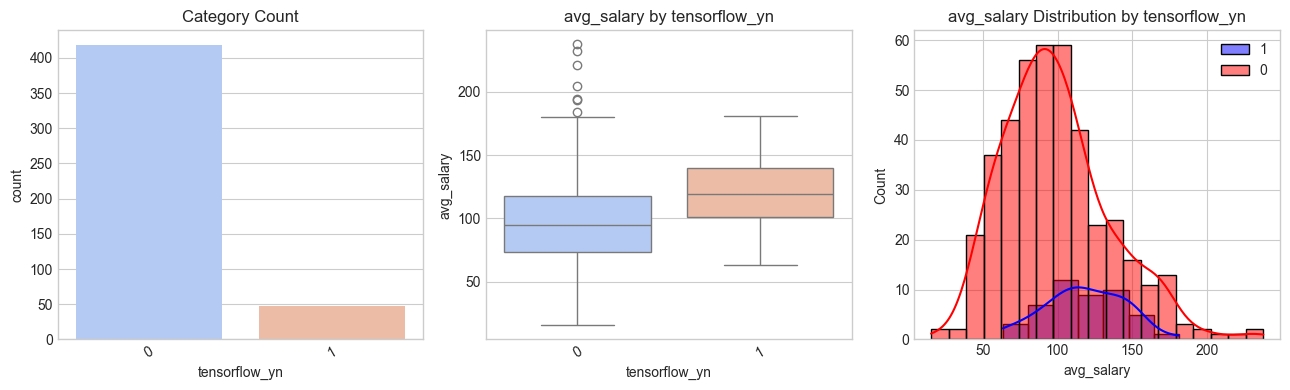

--------------------------------------------------
--------------------------------------------------

===== Analysis of keras_yn vs avg_salary_boxcox (Binary - Transformed) =====

Category Counts:
keras_yn
0    446
1     19
Name: count, dtype: int64

T-test on avg_salary_boxcox: Statistic = 4.4152, p-value = 0.0002
✅ keras_yn is a significant predictor of avg_salary_boxcox.

Mean Difference (original target): 22.17
Std. Deviation of Difference (original target): 5.73


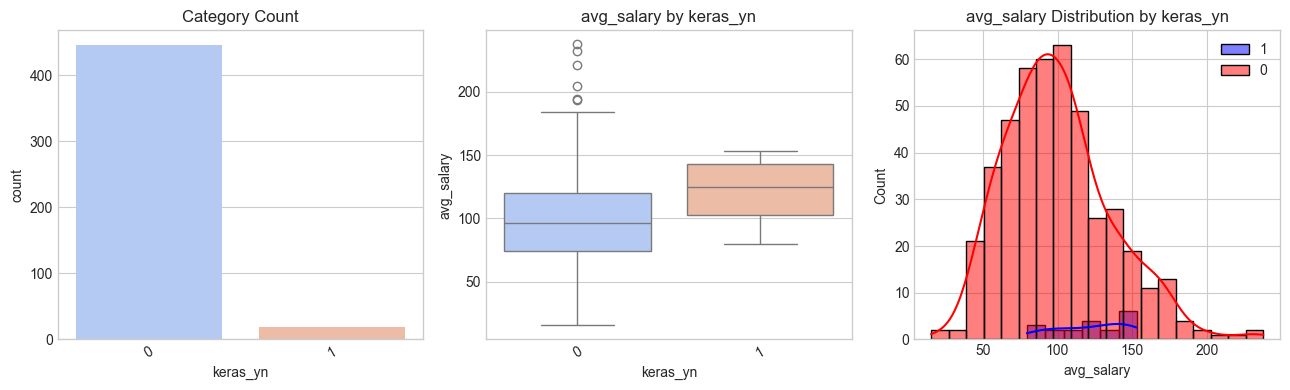

--------------------------------------------------
--------------------------------------------------

===== Analysis of pytorch_yn vs avg_salary_boxcox (Binary - Transformed) =====

Category Counts:
pytorch_yn
0    441
1     24
Name: count, dtype: int64

T-test on avg_salary_boxcox: Statistic = 2.1184, p-value = 0.0426
✅ pytorch_yn is a significant predictor of avg_salary_boxcox.

Mean Difference (original target): 8.06
Std. Deviation of Difference (original target): 4.97


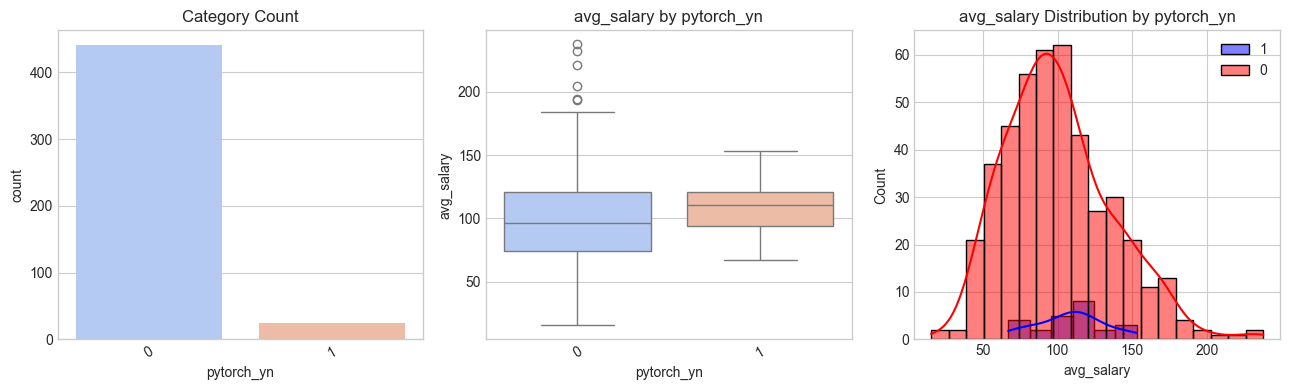

--------------------------------------------------
--------------------------------------------------

===== Analysis of scikit-learn_yn vs avg_salary_boxcox (Binary - Transformed) =====

Category Counts:
scikit-learn_yn
0    435
1     30
Name: count, dtype: int64

T-test on avg_salary_boxcox: Statistic = 3.9715, p-value = 0.0003
✅ scikit-learn_yn is a significant predictor of avg_salary_boxcox.

Mean Difference (original target): 23.24
Std. Deviation of Difference (original target): 6.66


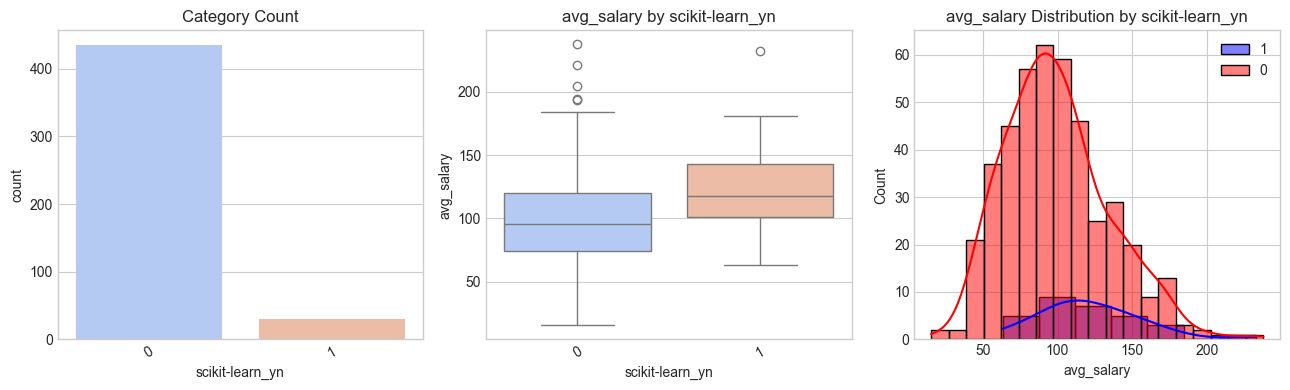

--------------------------------------------------
--------------------------------------------------

===== Analysis of matplotlib_yn vs avg_salary_boxcox (Binary - Transformed) =====

Category Counts:
matplotlib_yn
0    457
1      8
Name: count, dtype: int64

T-test on avg_salary_boxcox: Statistic = 1.9324, p-value = 0.0929
❌ matplotlib_yn does not show a statistically significant relationship with avg_salary_boxcox.
--------------------------------------------------
--------------------------------------------------

===== Analysis of snowflake_yn vs avg_salary_boxcox (Binary - Transformed) =====

Category Counts:
snowflake_yn
0    448
1     17
Name: count, dtype: int64

T-test on avg_salary_boxcox: Statistic = -0.3360, p-value = 0.7409
❌ snowflake_yn does not show a statistically significant relationship with avg_salary_boxcox.
--------------------------------------------------
--------------------------------------------------

===== Analysis of numpy_yn vs avg_salary_boxcox (Bina

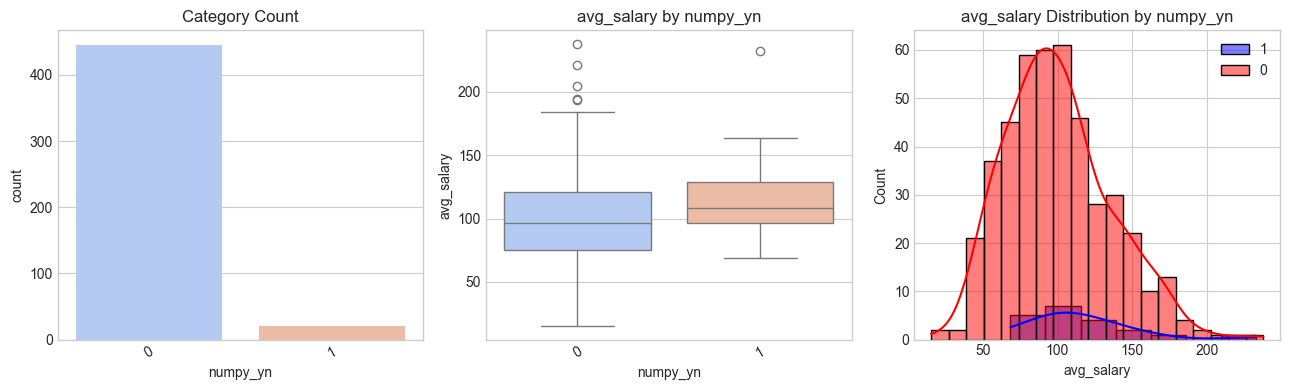

--------------------------------------------------
--------------------------------------------------

===== Analysis of pandas_yn vs avg_salary_boxcox (Binary - Transformed) =====

Category Counts:
pandas_yn
0    435
1     30
Name: count, dtype: int64

T-test on avg_salary_boxcox: Statistic = 2.9464, p-value = 0.0058
✅ pandas_yn is a significant predictor of avg_salary_boxcox.

Mean Difference (original target): 18.27
Std. Deviation of Difference (original target): 7.01


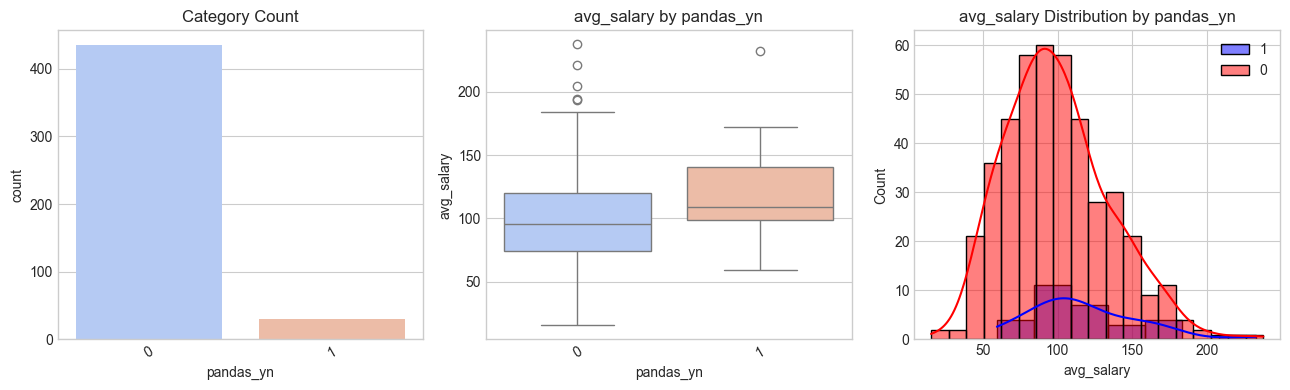

--------------------------------------------------
--------------------------------------------------

===== Analysis of scipy_yn vs avg_salary_boxcox (Binary - Transformed) =====

Category Counts:
scipy_yn
0    456
1      9
Name: count, dtype: int64

T-test on avg_salary_boxcox: Statistic = 1.9751, p-value = 0.0826
❌ scipy_yn does not show a statistically significant relationship with avg_salary_boxcox.
--------------------------------------------------
--------------------------------------------------

===== Analysis of bigquery_yn vs avg_salary_boxcox (Binary - Transformed) =====

Category Counts:
bigquery_yn
0    454
1     11
Name: count, dtype: int64

T-test on avg_salary_boxcox: Statistic = 0.6458, p-value = 0.5319
❌ bigquery_yn does not show a statistically significant relationship with avg_salary_boxcox.
--------------------------------------------------
--------------------------------------------------

===== Analysis of aws_yn vs avg_salary_boxcox (Binary - Transformed) ===

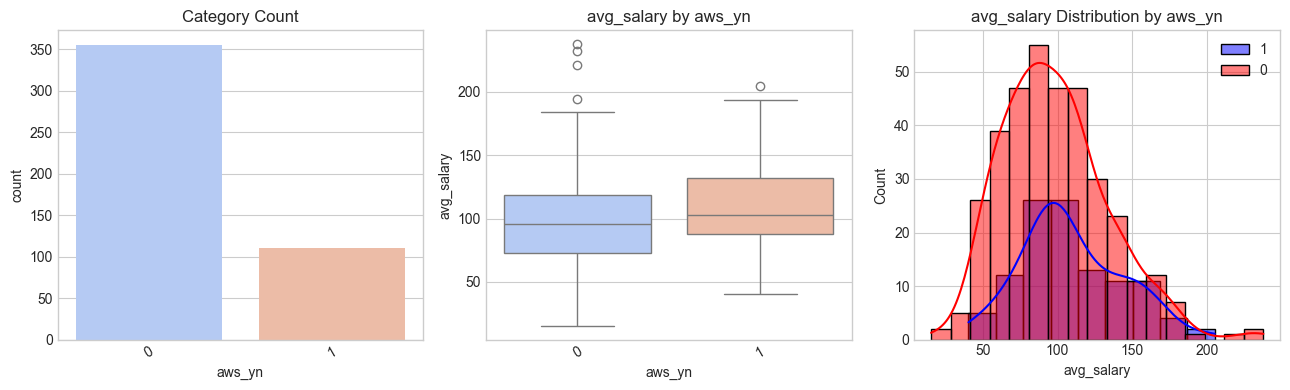

--------------------------------------------------
--------------------------------------------------

===== Analysis of azure_yn vs avg_salary_boxcox (Binary - Transformed) =====

Category Counts:
azure_yn
0    428
1     37
Name: count, dtype: int64

T-test on avg_salary_boxcox: Statistic = 0.1622, p-value = 0.8719
❌ azure_yn does not show a statistically significant relationship with avg_salary_boxcox.
--------------------------------------------------
--------------------------------------------------

===== Analysis of google cloud_yn vs avg_salary_boxcox (Binary - Transformed) =====

Category Counts:
google cloud_yn
0    445
1     20
Name: count, dtype: int64

T-test on avg_salary_boxcox: Statistic = 1.5789, p-value = 0.1296
❌ google cloud_yn does not show a statistically significant relationship with avg_salary_boxcox.
--------------------------------------------------
--------------------------------------------------

===== Analysis of airflow_yn vs avg_salary_boxcox (Binary - 

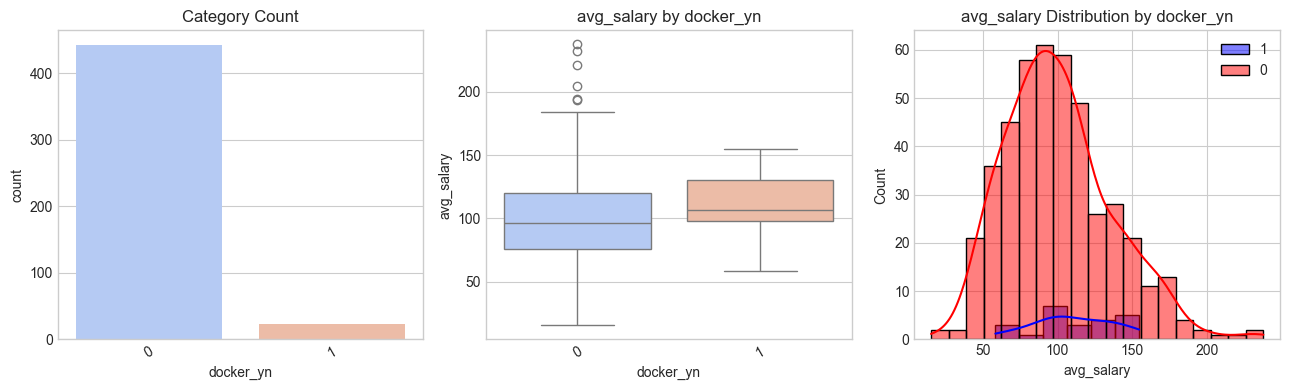

--------------------------------------------------
--------------------------------------------------

===== Analysis of kubernetes_yn vs avg_salary_boxcox (Binary - Transformed) =====

Category Counts:
kubernetes_yn
0    452
1     13
Name: count, dtype: int64

T-test on avg_salary_boxcox: Statistic = 1.1174, p-value = 0.2804
❌ kubernetes_yn does not show a statistically significant relationship with avg_salary_boxcox.
--------------------------------------------------
--------------------------------------------------

===== Analysis of r_yn vs avg_salary_boxcox (Binary - Transformed) =====

Category Counts:
r_yn
0    280
1    185
Name: count, dtype: int64

T-test on avg_salary_boxcox: Statistic = 4.4027, p-value = 0.0000
✅ r_yn is a significant predictor of avg_salary_boxcox.

Mean Difference (original target): 14.08
Std. Deviation of Difference (original target): 3.31


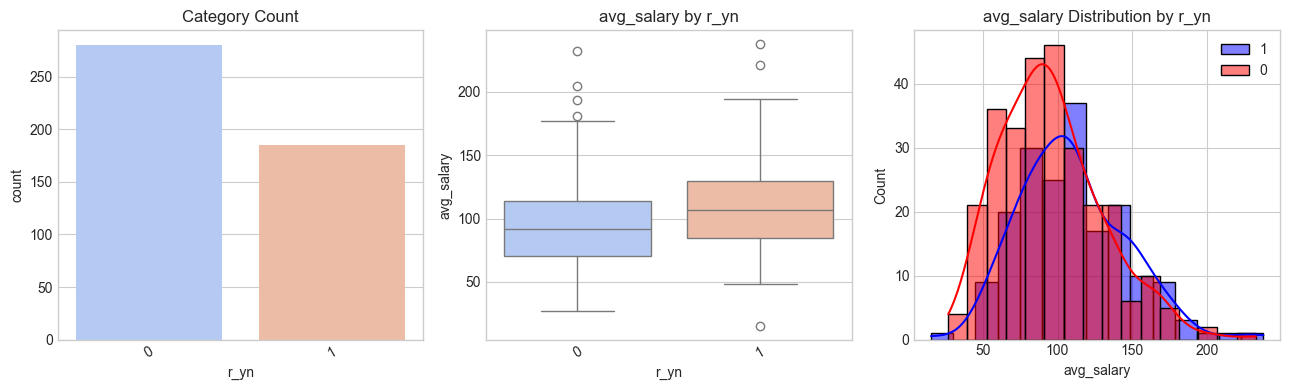

In [41]:
col_list = []
mean_list = []
var_list = []


for column in df_binary:
        print("-" * 50)
        print("-" * 50)
        result = f.analyze_binary_vs_target(df_analysis, column, 'avg_salary', 'avg_salary_boxcox')  # Asegúrate de que la función esté correctamente definida

        if result:  # Solo añade si no es ""
            col_name, mean_value, var_value = result
            col_list.append(col_name)
            mean_list.append(mean_value)
            var_list.append(var_value)


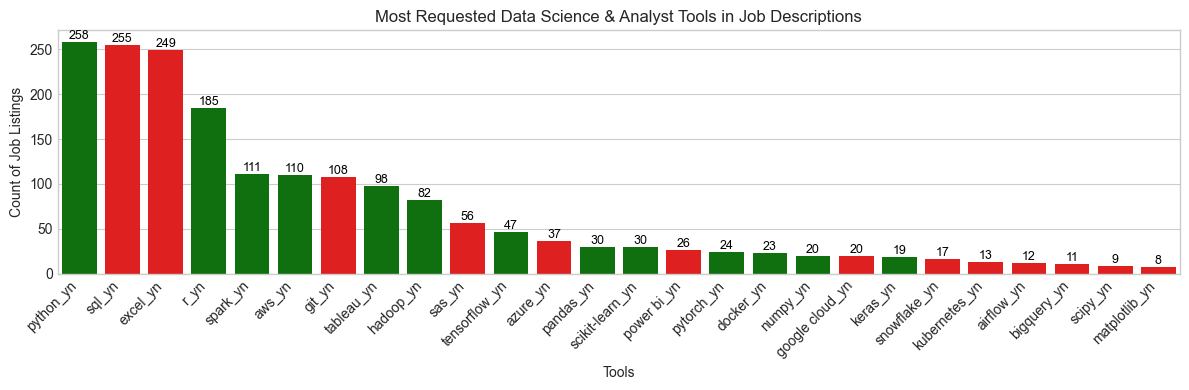

13 non-significant tools were removed.


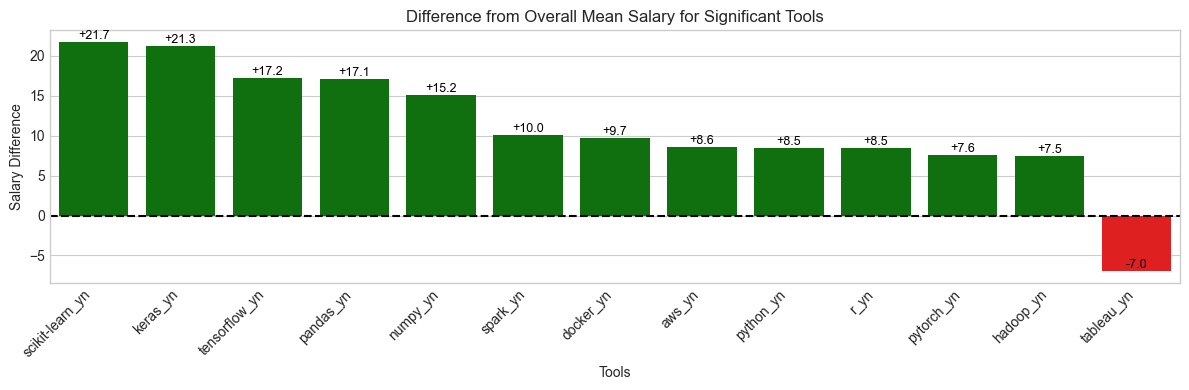

13 non-significant tools were removed.
13 non-significant tools were removed.


In [42]:
df_analysis, num_removed, df_significant = f.analyze_and_filter_tools(df_analysis, df_binary, col_list)
df_modeling_linear, num_removed, df_significant = f.analyze_and_filter_tools(df_modeling_linear, df_binary, col_list,show_plots = False)
df_modeling_tree, num_removed, df_significant = f.analyze_and_filter_tools(df_modeling_tree, df_binary, col_list, show_plots=False)


> Most of the significant tools are Python-related, which could introduce multicollinearity if used together in regression. To address this, we consolidated them into a single feature.


In [43]:
# Refresh DataFrame list
all_dfs = [df_analysis, df_modeling_tree, df_modeling_linear]

# === Grouping Tools by Category ===

# 1. Python-related tools
python_specific_tools = ['scikit-learn_yn', 'keras_yn', 'pandas_yn', 'tensorflow_yn', 'pytorch_yn', 'numpy_yn']
python_main_col = 'python_yn'

# 2. Big Data tools
big_data_tools = ['spark_yn', 'hadoop_yn']

# 3. Cloud tools
cloud_tools = ['aws_yn', 'docker_yn']

for i in range(len(all_dfs)):
    df = all_dfs[i]

    # --- Group Python tools ---
    df["python_tool_yn"] = df[python_specific_tools].astype(int).sum(axis=1).clip(upper=1)

    # Avoid double-counting: remove base python_yn if subtools are present
    df.loc[df["python_tool_yn"] == 1, python_main_col] = 0

    # Drop original Python-specific tools
    df.drop(columns=[col for col in python_specific_tools if col in df.columns], inplace=True)

    # --- Group Big Data tools ---
    df["big_data_yn"] = df[big_data_tools].any(axis=1).astype(int)

    # Drop original Big Data columns
    df.drop(columns=[col for col in big_data_tools if col in df.columns], inplace=True)

    # --- Combine Big Data and Cloud tools ---
    combined_cols = ["big_data_yn"] + [col for col in cloud_tools if col in df.columns]
    df["cloud_or_big_data_yn"] = df[combined_cols].any(axis=1).astype(int)

    # Drop original cloud and big data columns
    df.drop(columns=[col for col in cloud_tools if col in df.columns] + ["big_data_yn"], inplace=True)

    all_dfs[i] = df

# Reassign final versions
df_analysis, df_modeling_tree, df_modeling_linear = all_dfs

# Summary from df_analysis only
print("\n✅ Final binary column summary (df_analysis):")
print(df_analysis[["python_yn", "python_tool_yn", "cloud_or_big_data_yn"]].sum())



✅ Final binary column summary (df_analysis):
python_yn               197
python_tool_yn           70
cloud_or_big_data_yn    187
dtype: int64


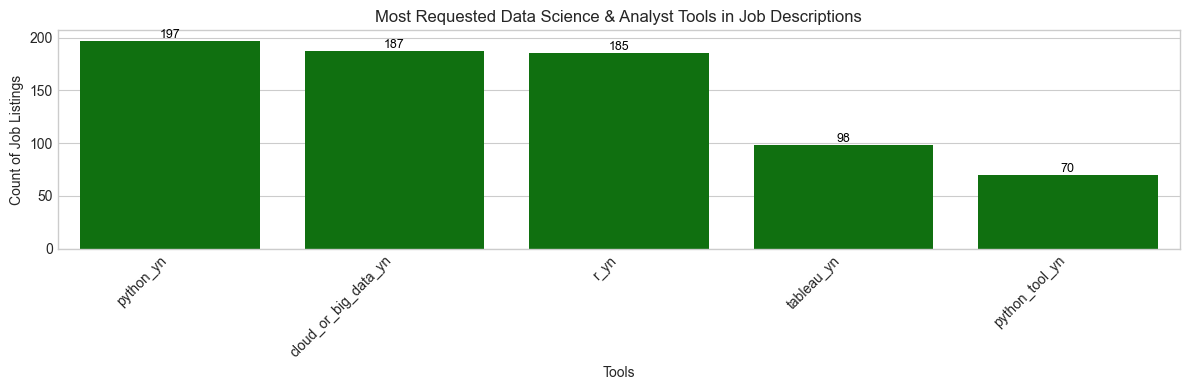

0 non-significant tools were removed.


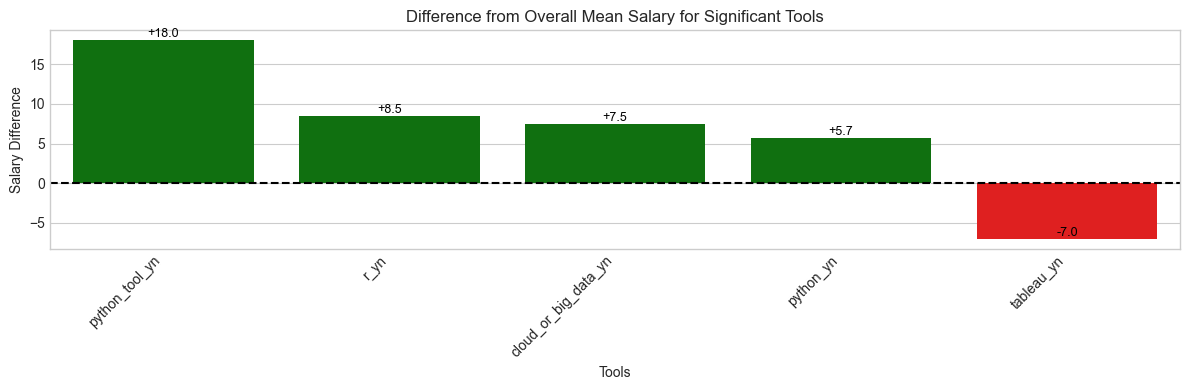

In [44]:
col_list.extend(['python_tool_yn', 'cloud_or_big_data_yn'])
df_binary = df_analysis.loc[:, df.nunique() == 2]
df_analysis, num_removed, df_significant = f.analyze_and_filter_tools(df_analysis, df_binary, col_list)


## 6. Cost of Living Analysis by US Region



To understand how far salaries go in different parts of the United States, we combined salary data with cost of living estimates from the **US Family Budget Dataset**, based on the **Family Budget Calculator** by the Economic Policy Institute (EPI).

This dataset provides annual cost estimates for various household types across **1,877 counties and metro areas** in the US. For this analysis, we focused on a **family of four (2 parents, 2 children)** and considered the **sum of four essential annual expenses**:

- **Housing**
- **Food**
- **Transportation**
- **Healthcare**

By aggregating these costs for cities within each state, we aim to identify **which regions offer the best salary-to-cost-of-living ratio**.


In [45]:
# Load the dataset
df_house = pd.read_csv('../Data/cost_of_living_us.csv')


In [46]:
df_house = f.basic_data_checks(df_house)

📐 Initial DataFrame shape: (31430, 15)
⚠️ Total missing values: 10
Missing values by column:
median_family_income    10
dtype: int64
✅ No duplicate rows found.

🔍 Data types:
case_id                     int64
state                      object
isMetro                      bool
areaname                   object
county                     object
family_member_count        object
housing_cost              float64
food_cost                 float64
transportation_cost       float64
healthcare_cost           float64
other_necessities_cost    float64
childcare_cost            float64
taxes                     float64
total_cost                float64
median_family_income      float64
dtype: object


In [47]:
df_house.drop(columns=['case_id','isMetro','median_family_income',"childcare_cost","areaname","county"], inplace=True)

In [48]:
df_house.head(3)

state family_member_count  housing_cost   food_cost  transportation_cost  \
0    AL                1p0c    8505.72876  3454.91712          10829.16876   
1    AL                1p1c   12067.50240  5091.70788          11588.19288   
2    AL                1p2c   12067.50240  7460.20308          12361.77720   

   healthcare_cost  other_necessities_cost       taxes  total_cost  
0       5737.47984              4333.81344  6392.94504  39254.0532  
1       8659.55640              6217.45896  7422.07836  57194.3256  
2      11581.63260              7075.65816  9769.56228  76141.0308

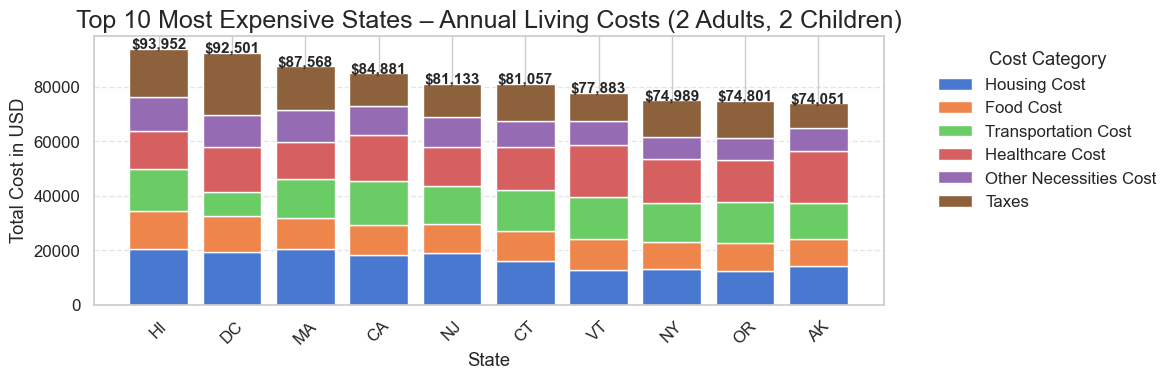

In [49]:
# Estilo general
sns.set(style="whitegrid", font_scale=1.1)

# Filter for family type
df_2p2c = df_house[df_house['family_member_count'] == '2p2c']

# Define cost components
cost_columns = [
    'housing_cost',
    'food_cost',
    'transportation_cost',
    'healthcare_cost',
    'other_necessities_cost',
    'taxes'
]

# Compute average cost per state
state_avg_costs = df_2p2c.groupby('state')[cost_columns].mean()
state_avg_costs['total_cost'] = state_avg_costs[cost_columns].sum(axis=1)

# Top 10 most expensive states
top10_states = state_avg_costs.sort_values(by='total_cost', ascending=False).head(10)
top10_sorted = top10_states.sort_values(by='total_cost', ascending=False)

# Colors (pastel tone)
colors = sns.color_palette("muted", len(cost_columns))

# Plot
plt.figure(figsize=(12, 4))
bottom = None

for i, col in enumerate(cost_columns):
    plt.bar(
        top10_sorted.index,
        top10_sorted[col],
        bottom=bottom,
        label=col.replace('_', ' ').title(),
        color=colors[i]
    )
    bottom = top10_sorted[col] if bottom is None else bottom + top10_sorted[col]

# Add total value on top of each bar
for idx, total in enumerate(top10_sorted['total_cost']):
    plt.text(idx, total + 100, f"${int(total):,}", ha='center', fontsize=11, fontweight='bold')

# Styling
plt.title('Top 10 Most Expensive States – Annual Living Costs (2 Adults, 2 Children)', fontsize=18)
plt.ylabel('Total Cost in USD')
plt.xlabel('State')
plt.xticks(rotation=45)
plt.legend(title='Cost Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
os.makedirs("images", exist_ok=True)
plt.savefig("../images/cost_breakdown_top_states.png", bbox_inches="tight", dpi=300)
plt.show()



In [50]:
# Apply state group mapping to df_house
df_2p2c['Region'] = df_2p2c['state'].map(state_group_mapping)

df_analysis['Region'] = df_analysis["job_state_grouped"]

# Recalculate average cost per mapped state
cost_columns = [
    'housing_cost',
    'food_cost',
    'transportation_cost',
    'healthcare_cost',
    'other_necessities_cost',
    'taxes'
]

# Group by the mapped state and calculate the average salary
salary_by_state = df_analysis.groupby('Region')['avg_salary'].mean().reset_index()
salary_by_state['avg_salary'] = (salary_by_state['avg_salary'] * 1000).round(0)

#print(salary_by_state)

state_avg_costs = df_2p2c.groupby('Region')[cost_columns].mean().round(0)
state_avg_costs['total_cost'] = state_avg_costs[cost_columns].sum(axis=1)
state_avg_costs = state_avg_costs.reset_index()

# Merge with average salary data
merged = pd.merge(salary_by_state, state_avg_costs, on='Region', how='inner')

# Calculate surplus/deficit
merged['surplus'] = merged['avg_salary'] - merged['total_cost']
# Opción 1: crear un nuevo DataFrame directamente
print(merged[['Region', 'avg_salary', 'total_cost', 'surplus']])
#print(merged['avg_salary'] - merged['total_cost'])









            Region  avg_salary  total_cost  surplus
0               CA    123423.0     84882.0  38541.0
1               IL    105548.0     67854.0  37694.0
2               MA    105817.0     87568.0  18249.0
3               MD     98955.0     69650.0  29305.0
4    Midwest Other     84625.0     63826.0  20799.0
5               NY    100234.0     74989.0  25245.0
6  Northeast Other     95771.0     69977.0  25794.0
7      South Other     87761.0     62787.0  24974.0
8               VA     97667.0     69466.0  28201.0
9       West Other     84915.0     68883.0  16032.0


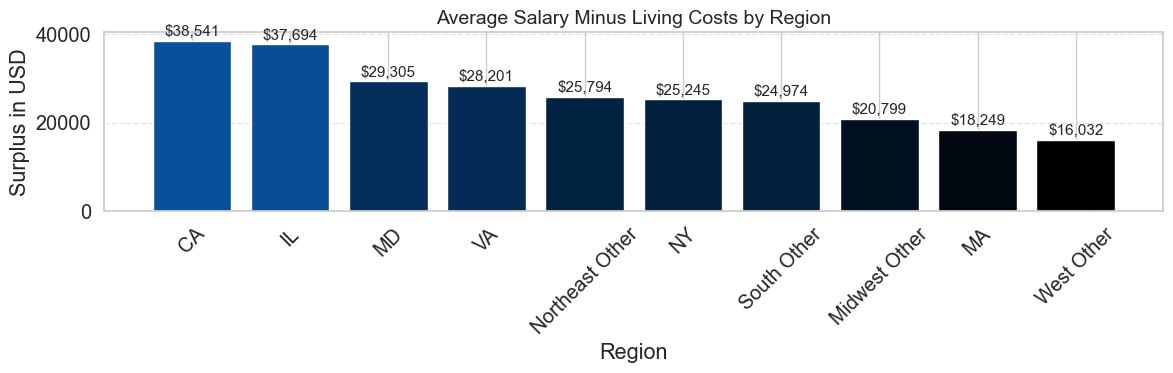

In [51]:

import matplotlib.cm as cm


# Sort by surplus
sns.set(style="whitegrid", font_scale=1.3)

merged_sorted = merged.sort_values(by='surplus', ascending=False)

# Normalize surplus values between 0 and 1 for color mapping
norm = plt.Normalize(merged_sorted['surplus'].min(), merged_sorted['surplus'].max())
#colors = cm.Purples(norm(merged_sorted['surplus']))  # You can also try 'plasma', 'coolwarm', 'RdYlGn'
#colors = cm.YlGnBu(norm(merged_sorted['surplus']))
base_color = sns.color_palette("Blues", 7)[-1]  # color más oscuro
intensity = norm(merged_sorted['surplus'])
colors = [(base_color[0]*i, base_color[1]*i, base_color[2]*i) for i in intensity]


# Plot
plt.figure(figsize=(12, 4))
bars = plt.bar(merged_sorted['Region'], merged_sorted['surplus'], color=colors)

# Annotate values
for i, val in enumerate(merged_sorted['surplus']):
    plt.text(i, val + 500 if val > 0 else val - 2000, f"${int(val):,}", 
             ha='center', va='bottom' if val > 0 else 'top', fontsize=11)

# Styling
plt.title('Average Salary Minus Living Costs by Region', fontsize=14)
plt.ylabel('Surplus in USD')
plt.xlabel('Region')
plt.xticks(rotation=45)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
os.makedirs("images", exist_ok=True)
plt.savefig("../images/salary_surplus_barplot.png", bbox_inches="tight", dpi=300)
plt.show()



In [52]:
merged[["Region", "avg_salary", "total_cost", "surplus"]    ]

Region  avg_salary  total_cost  surplus
0               CA    123423.0     84882.0  38541.0
1               IL    105548.0     67854.0  37694.0
2               MA    105817.0     87568.0  18249.0
3               MD     98955.0     69650.0  29305.0
4    Midwest Other     84625.0     63826.0  20799.0
5               NY    100234.0     74989.0  25245.0
6  Northeast Other     95771.0     69977.0  25794.0
7      South Other     87761.0     62787.0  24974.0
8               VA     97667.0     69466.0  28201.0
9       West Other     84915.0     68883.0  16032.0

In [53]:
# Invertimos el state_group_mapping → para saber qué estados pertenecen a cada región
from collections import defaultdict
region_to_states = defaultdict(list)

for state, region in state_group_mapping.items():
    region_to_states[region].append(state)

# Creamos nuevo DataFrame a nivel estado
rows = []

for _, row in merged.iterrows():
    region = row['Region']
    states = region_to_states[region]
    
    for state in states:
        rows.append({
            'state': state,
            'avg_salary': row['avg_salary'],
            'total_cost': row['total_cost'],
            'surplus': row['surplus']
        })

state_level_df = pd.DataFrame(rows)


In [54]:
import plotly.express as px

fig = px.choropleth(
    state_level_df,
    locations='state',
    locationmode='USA-states',
    color='surplus',
    color_continuous_scale='Blues',
    range_color=[merged['surplus'].min(), merged['surplus'].max()],
    scope='usa',
    labels={'surplus': 'Salary Surplus (USD)'},
    title='💰 Salary Surplus by State (Avg. Salary – Living Costs)'
)

fig.update_layout(
    geo_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='white',
    paper_bgcolor='white'
)

fig.show()

# Exportar en alta calidad (2x escala)
fig.write_image("images/salary_surplus_map.png", scale=2)


## 7. Summary

In [55]:
df.columns

Index(['Rating', 'Company Name', 'Size', 'Type of ownership', 'Industry',
       'Sector', 'Revenue', 'weight', 'Job Category',
       'Merged Experience Category', 'avg_salary', 'job_state', 'python_yn',
       'tableau_yn', 'r_yn', 'Description_len', 'avg_salary_log',
       'avg_salary_boxcox', 'boxcox_lambda', 'age_category',
       'Size_recategorized', 'Industry Recategorized', 'Revenue_recategorized',
       'Region', 'job_state_grouped', 'python_tool_yn',
       'cloud_or_big_data_yn'],
      dtype='object')

### a. Drop Columns and rename

In [56]:
# Refresh the DataFrame list
all_dfs = [df_analysis, df_modeling_tree, df_modeling_linear]

# Columns to drop
columns_to_drop = [
    "Industry",                # replaced by Industry_Group
    "Revenue",                 # replaced by Revenue_Group
    "Size",                    # replaced by Company_Size
    "avg_salary_log",          # not used
    "job_state",               # replaced by Region
    "Company Name",            # not needed
    "job_state_grouped"        # replaced by Region
]

# Columns to rename
columns_to_rename = {
    "Type of ownership": "Ownership_Type",
    "Job Category": "Job_Function",
    "Merged Experience Category": "Experience_Level",
    "python_yn": "Python_Knowledge",
    "r_yn": "R_Knowledge",
    "tableau_yn": "Tableau_Knowledge",
    "python_tool_yn": "Python_Tools_Knowledge",
    "cloud_or_big_data_yn": "Cloud_or_BigData_Knowledge",
    "avg_salary_boxcox": "BoxCox_Avg_Salary",
    "age_category": "Age_Group",
    "Size_recategorized": "Company_Size",
    "Industry Recategorized": "Industry_Group",
    "Revenue_recategorized": "Revenue_Group"
}

# Apply to all DataFrames
for i in range(len(all_dfs)):
    df = all_dfs[i]

    # Drop columns if they exist
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

    # Rename columns safely
    df = df.rename(columns={k: v for k, v in columns_to_rename.items() if k in df.columns})

    all_dfs[i] = df

# Reassign updated versions
df_analysis, df_modeling_tree, df_modeling_linear = all_dfs

print("✅ Unnecessary columns dropped and key columns renamed across all DataFrames.")


✅ Unnecessary columns dropped and key columns renamed across all DataFrames.


### b. Data Cleaning Highlights

Several preprocessing steps were applied to improve data quality and ensure interpretability:

- **Grouped sparse categories** to avoid overfitting and improve ANOVA significance:
  - `Industry` was reduced from 12 to 5 categories.
  - `Revenue`, `Size`, `Sector` and `Job State` were also recategorized into broader, interpretable groups.
  
- **Filtered tools and technologies**:
  - Only tools with meaningful prevalence across job categories were kept.
  - Low-frequency tools (e.g., `sas_yn`, `tensorflow_yn`) were excluded unless relevant.

- **Applied transformations** to stabilize variance:
  - Box-Cox transformation was used on the salary variable for normality.

These steps helped reduce noise, improve statistical power, and prepare the data for downstream modeling.

### c. Export

In [57]:
import os

# Crear carpeta si no existe
os.makedirs("../Data", exist_ok=True)

# Nombres de archivo para cada DataFrame
file_names_model = [
    "df_analysis_model.csv",
    "df_modeling_tree_model.csv",
    "df_modeling_linear_model.csv"
]

# Exportar cada DataFrame a la carpeta ../Data/
exported_files = []

for df, name in zip([df_analysis, df_modeling_tree, df_modeling_linear], file_names_model):
    full_path = f"../Data/{name}"
    df.to_csv(full_path, index=False)
    exported_files.append(full_path)

print("✅ Exported files:", exported_files)


✅ Exported files: ['../Data/df_analysis_model.csv', '../Data/df_modeling_tree_model.csv', '../Data/df_modeling_linear_model.csv']
